In [1]:
import nibabel as nib
import torch
from torch.nn import functional as F
import torchvision
from matplotlib import pyplot as plt
from tqdm import tqdm 
import kornia as K
from plotting import plt_images_2,plot_3d_svf

import os
os.environ['NEURITE_BACKEND'] = 'pytorch'
import neurite as ne
import layers
from Regularization import TVRegulariser


In [2]:
device_type = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_type)
if device_type == 'cuda':
    print('GPU: ' + torch.cuda.get_device_name(0) + ', CUDA: ' + str(torch.cuda.is_available()))
else:
    print('CPU')

GPU: Quadro RTX 6000, CUDA: True


In [73]:
file1 = '/its/home/pi58/data/ExBox20/nodif.nii.gz'
file2 = '/its/home/pi58/data/ExBox20/nodif_PA.nii.gz'

img_pos = torch.tensor(nib.load(file1).get_fdata()).double().to(device)
img_inv = torch.tensor(nib.load(file2).get_fdata()).double().to(device)


#Rotating as the images are rotated. Need to do this irrespective of environment/library being used
img_pos = torch.rot90(img_pos, 1,[0,1])
img_inv = torch.rot90(img_inv, 1,[0,1])



img_pos = img_pos.permute(2,0,1) # making it (D,H,W) for kornia
img_inv = img_inv.permute(2,0,1)
img_pos = img_pos[None,:,:,:] #Adding (B,*spatial) additional 2 dimensions for kornia
img_inv = img_inv[None,:,:,:]


print("img_pos : ",img_pos.shape, "\n", "img_inv : ",img_inv.shape)


img_pos_pyramid = K.geometry.transform.build_pyramid(img_pos, 4)
img_inv_pyramid = K.geometry.transform.build_pyramid(img_inv, 4)
print("0 : ",img_pos_pyramid[0].shape, "\n", "-1 : ",img_pos_pyramid[-1].shape)

img_pos :  torch.Size([1, 76, 116, 116]) 
 img_inv :  torch.Size([1, 76, 116, 116])
0 :  torch.Size([1, 76, 116, 116]) 
 -1 :  torch.Size([1, 76, 14, 14])


In [75]:
file1 = '/its/home/pi58/data/ExBox20/nodif.nii.gz'
file2 = '/its/home/pi58/data/ExBox20/nodif_PA.nii.gz'

img_pos = torch.tensor(nib.load(file1).get_fdata()).double().to(device)
img_inv = torch.tensor(nib.load(file2).get_fdata()).double().to(device)


#Rotating as the images are rotated. Need to do this irrespective of environment/library being used
img_pos = torch.rot90(img_pos, 1,[0,1])
img_inv = torch.rot90(img_inv, 1,[0,1])



img_pos = img_pos.permute(2,0,1) # making it (D,H,W) for kornia
img_inv = img_inv.permute(2,0,1)
print(img_pos.shape)

torch.Size([76, 116, 116])


In [106]:
import airlab.utils.kernelFunction as kernelFunction
import airlab
import torch as th
import numpy as np
# pyramid = airlab.utils.image.create_image_pyramid(img_pos,2)
def build_image_pyramid(image, down_sample_factor):
   image_pyramide = []
   image_dim = len(image.shape)
   image_pyramide.append(image[None])
   for level in down_sample_factor:
      # sigma = (th.tensor(level)/2).to(dtype=th.float32)
      # print(sigma.shape)
      sigma = torch.tensor([1.5, 1.5, 1.5])
      kernel = kernelFunction.gaussian_kernel_3d(sigma.numpy(), asTensor=True)
      kernel.shape
      padding = np.array([(x - 1) / 2 for x in kernel.size()], dtype=int).tolist()
      kernel = kernel.unsqueeze(0).unsqueeze(0)
      kernel = kernel.to(dtype=image.dtype, device=image.device)
      # print(kernel.shape)
      image_sample = F.conv3d(image[None,None], kernel, stride=level, padding=padding) #output shape (B,C,D,H,W) 
      image_pyramide.append(image_sample.squeeze(0))#make this shape to (B,D,H,W)
   return image_pyramide
img_pos_pyramid = build_image_pyramid(img_pos,(2,4,8))
img_inv_pyramid = build_image_pyramid(img_pos,(2,4,8))

torch.Size([1, 76, 116, 116]) torch.Size([1, 38, 58, 58]) torch.Size([1, 19, 29, 29]) torch.Size([1, 10, 15, 15])


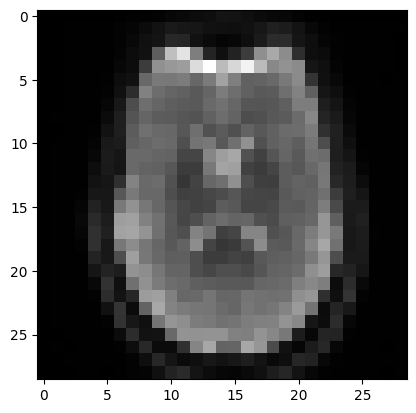

In [105]:
pyramid = build_image_pyramid(img_pos,(2,4,8))
print(pyramid[0].shape, pyramid[1].shape, pyramid[2].shape, pyramid[3].shape)
plt.imshow(pyramid[-2].squeeze(0).squeeze(0)[9].cpu(),cmap='gray')

In [243]:
from IPython.display import clear_output

def forward_model(template_img, grid, inv):
    '''
    Expected shape : template (1,d,h,w)
    Expected shape : grid (1,3,d,h,w)
    '''

    template_img = template_img.to(device)
    grid = grid.to(device)
    spatial_dims = (template_img.shape[2],template_img.shape[3],template_img.shape[4]) #(d,h,w)
    # print(spatial_dims)
    
    grid = -grid if(inv) else grid
    exp = layers.VecInt(device, spatial_dims, 8)
    disp = exp(grid) #input grid and output displacement field shape (1,3,*spatial)
    jac_det = layers.jacobian_determinant((disp).cpu()) #unit : voxels (image space) 
    jac_det = (torch.from_numpy(jac_det)).to(device) 
    # jac_det = (1-jac_det) if (inv) else (1+jac_det)
    template_img = template_img * jac_det #jacobian modulation 
    temp = template_img.clone()
    transformer = layers.SpatialTransformer(device, spatial_dims)
    warped = transformer.forward(template_img.float(),disp)
    # template_img = template_img / jac_det #jacobian modulation
    
    # jac_det = transformer.forward(jac_det.unsqueeze(0).unsqueeze(0).float(),grid)
    # warped = warped.squeeze(0).squeeze(0) * (jac_det.squeeze(0).squeeze(0))
    #returning shape (1,*spatial) and jacdet(*spatial)
    # return warped.unsqueeze(0).unsqueeze(0).to(torch.float64), jac_det.squeeze(0).squeeze(0)
    return warped.to(torch.float64), jac_det

In [237]:
#Testing forward function
test_img = (img_pos_pyramid[0][None,].to('cpu').float()) #+ img_inv_pyramid[0][None,].to('cpu').float())
grid = torch.randn(1,3,76,116,116,device='cpu') 
print(test_img.shape)
warped_pos, jac = forward_model(test_img,grid,inv=False)
warped_inv, ijac = forward_model(test_img,grid,inv=True)
# print(warped_pos.shape,jac.shape,warped_pos.dtype)
t = (warped_pos+warped_inv)/2
n = 40
i = 0
z = [warped_pos.detach().cpu()[:,:,:,:n,:n], img_pos_pyramid[i].detach().cpu()[:,:,:n,:n], warped_inv.detach().cpu()[:,:,:,:n,:n], img_inv_pyramid[i].detach().cpu()[:,:,:n,:n], t.detach().cpu()[:,:,:,:n,:n], jac.detach().cpu()[:,:n,:n], ijac.detach().cpu()[:,:n,:n]]

torch.Size([1, 1, 76, 116, 116])


In [244]:
#Initializations
template_img = (img_pos_pyramid[-1] + img_inv_pyramid[-1])/2
grid = torch.ones((template_img.shape[0],3,template_img.shape[1],template_img.shape[2],template_img.shape[3]),requires_grad=True,device=device)
grid = torch.nn.Parameter(grid)
template_img = torch.nn.Parameter(template_img[None,].float())
loss = torch.nn.GaussianNLLLoss()
# reg = TVRegulariser(pixel_spacing=[8,8,8]) #larger pixel spacing will lead to stronger reg effect
reg = K.losses.TotalVariation()
losses = {0:[],1:[],2:[],3:[],4:[]}


epochs = 100
learning_rate = 0.05
vmax_list = [6000,6000,6000,6000,6000,1,1]
v_list = ["warped_pos", "img_pos", "warped_inv", "img_inv","template_img","jac","ijac"]
h_list = ["magnitude", "magnitude", "magnitude", "magnitude","magnitude","log","log"]
slices = [36,37,38]
print(grid.shape,template_img.shape)

torch.Size([1, 3, 10, 15, 15]) torch.Size([1, 1, 10, 15, 15])


  0%|          | 0/100 [00:00<?, ?it/s]

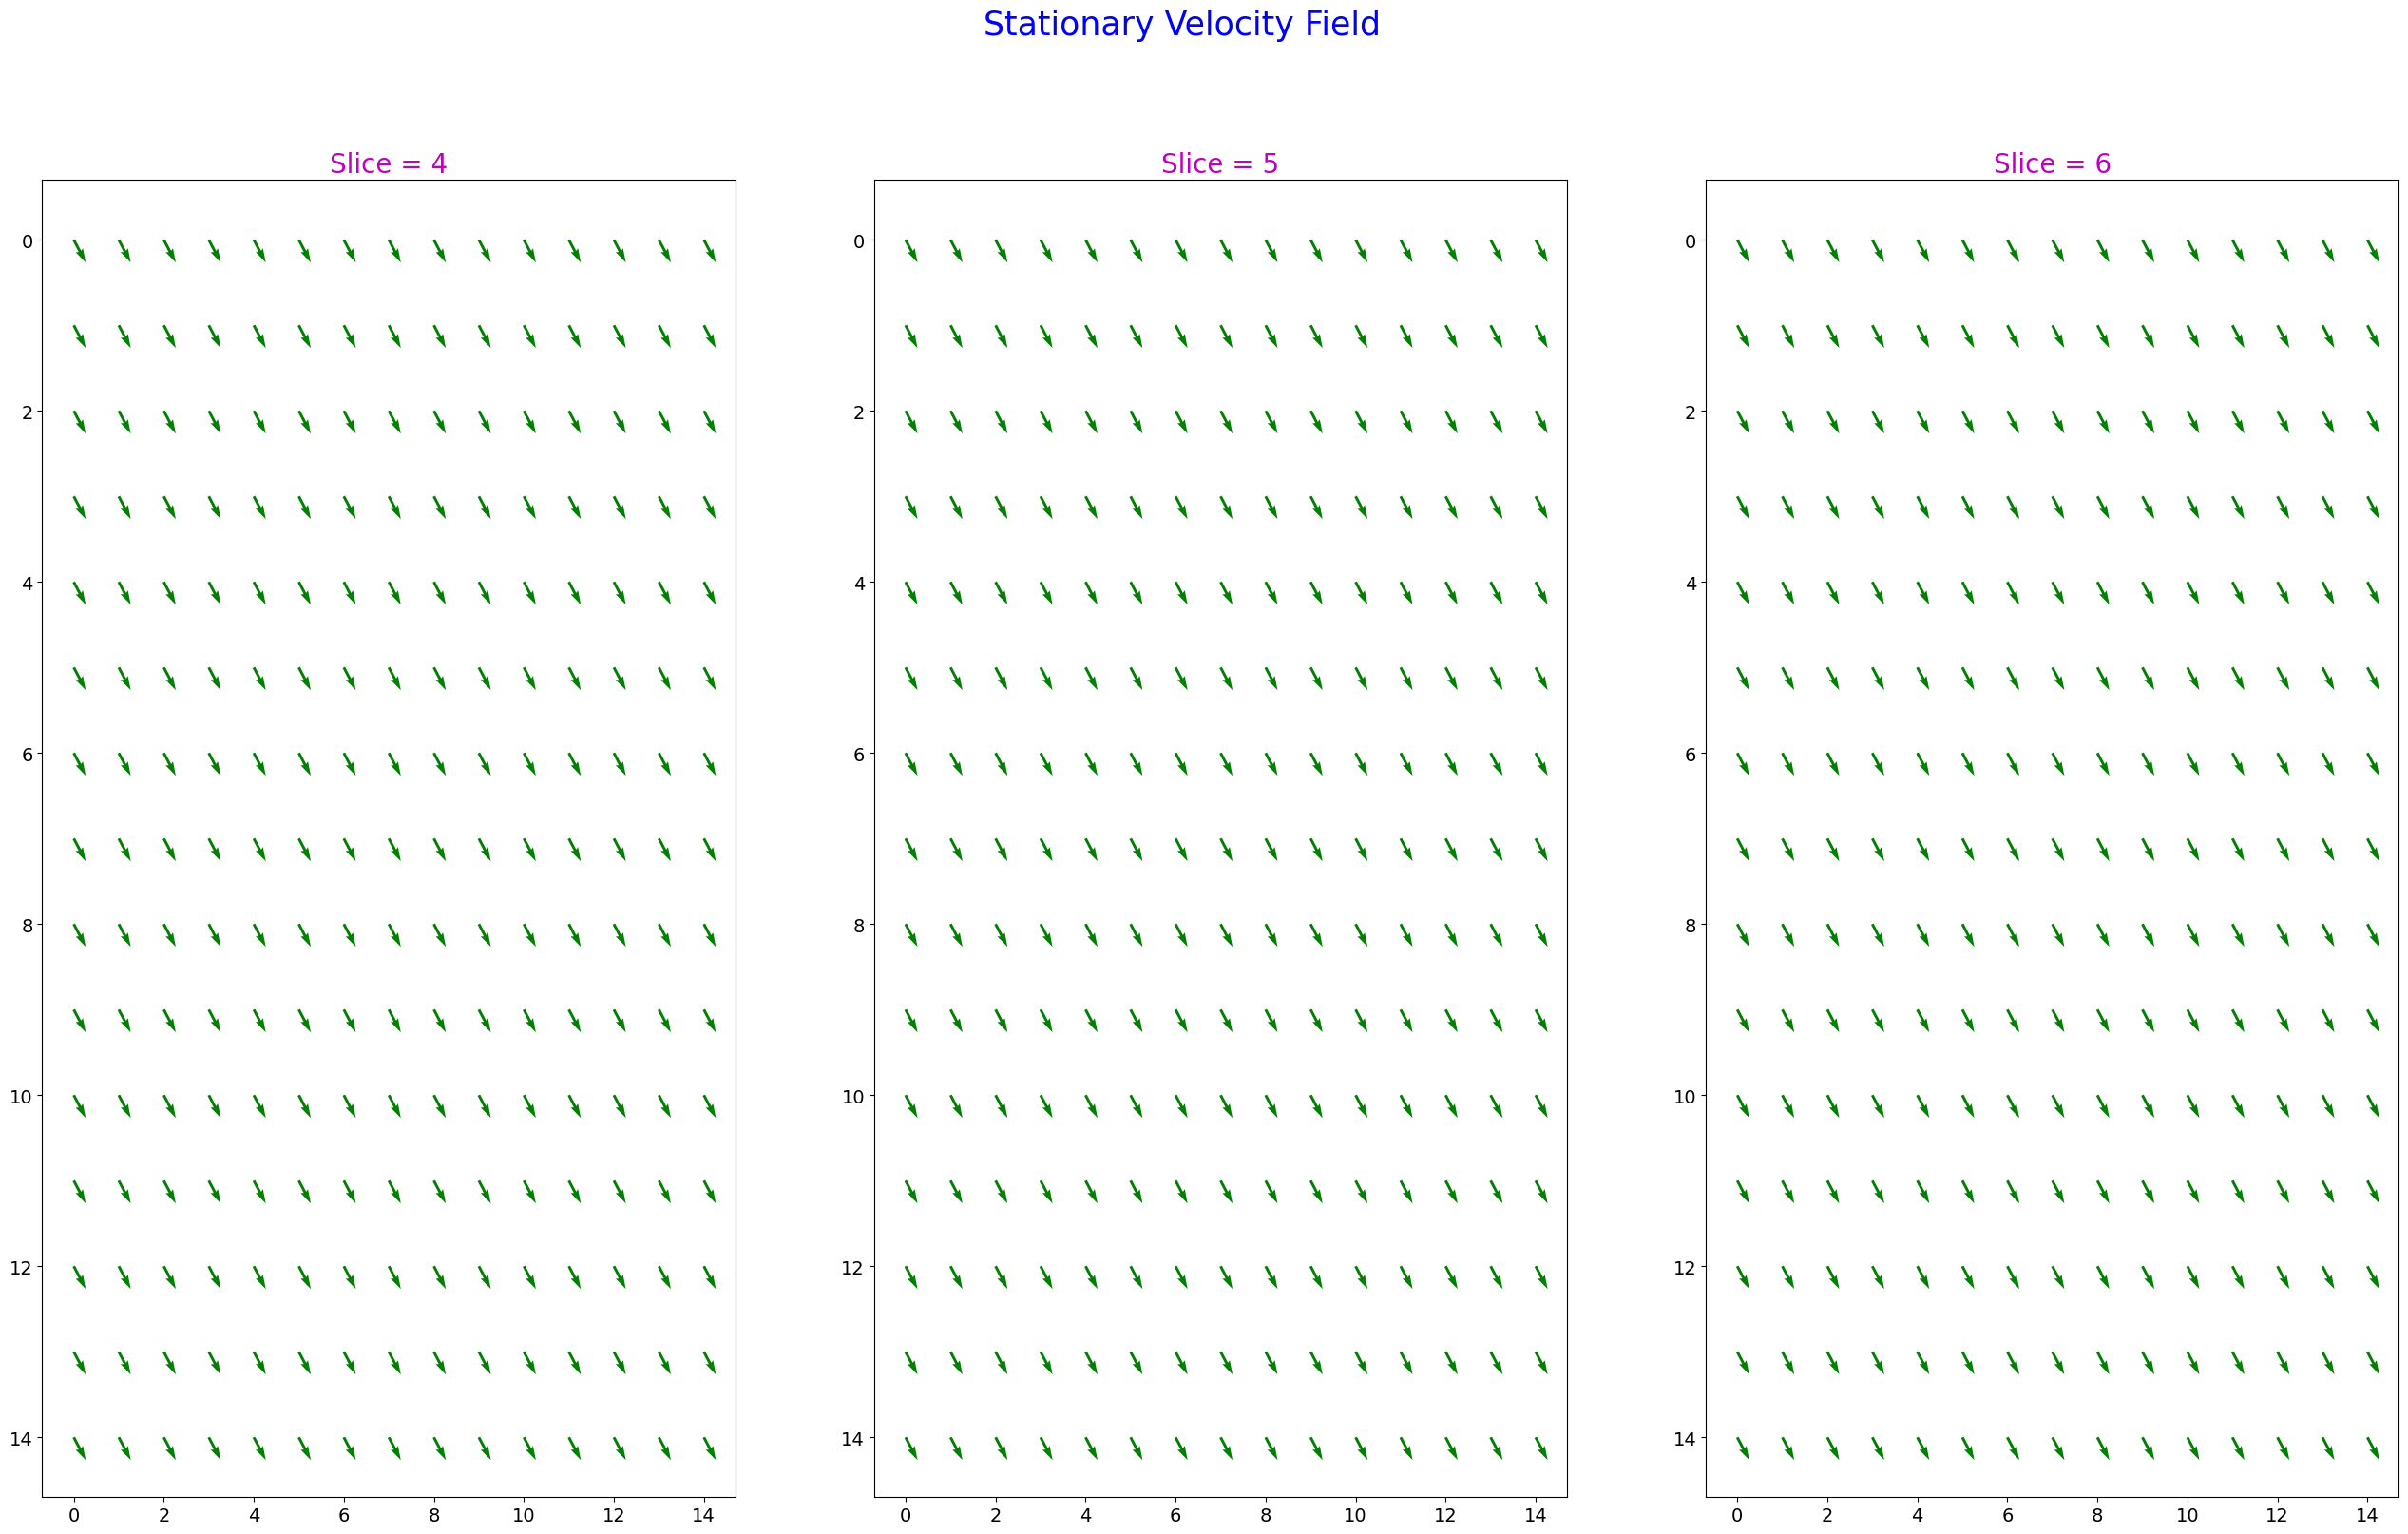

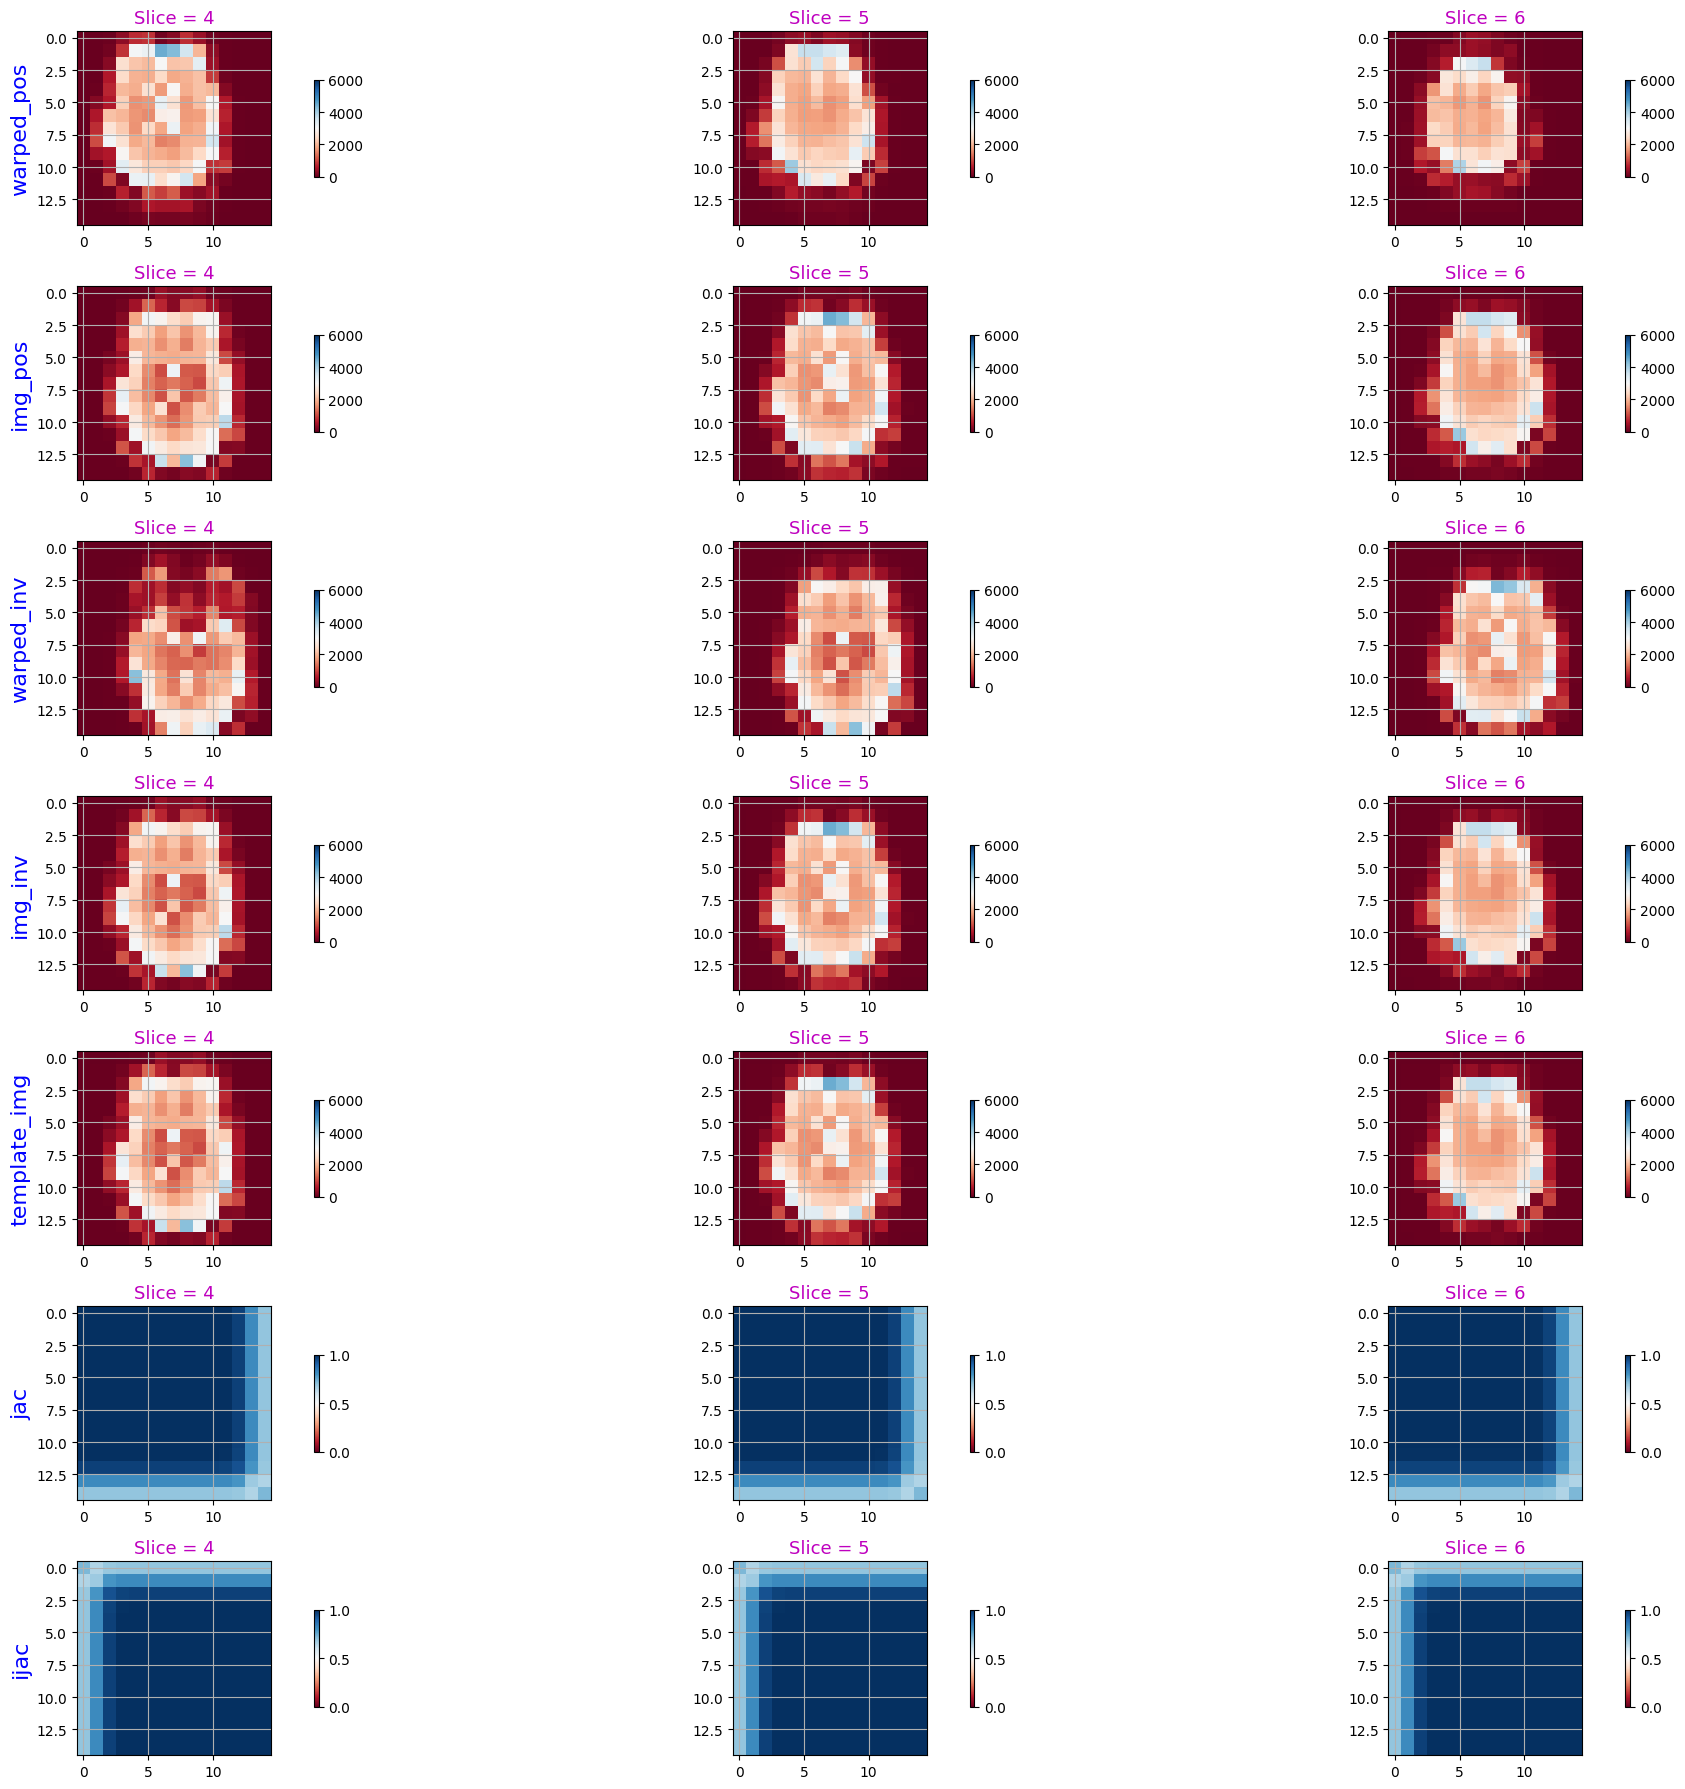

  0%|          | 0/70 [00:00<?, ?it/s]

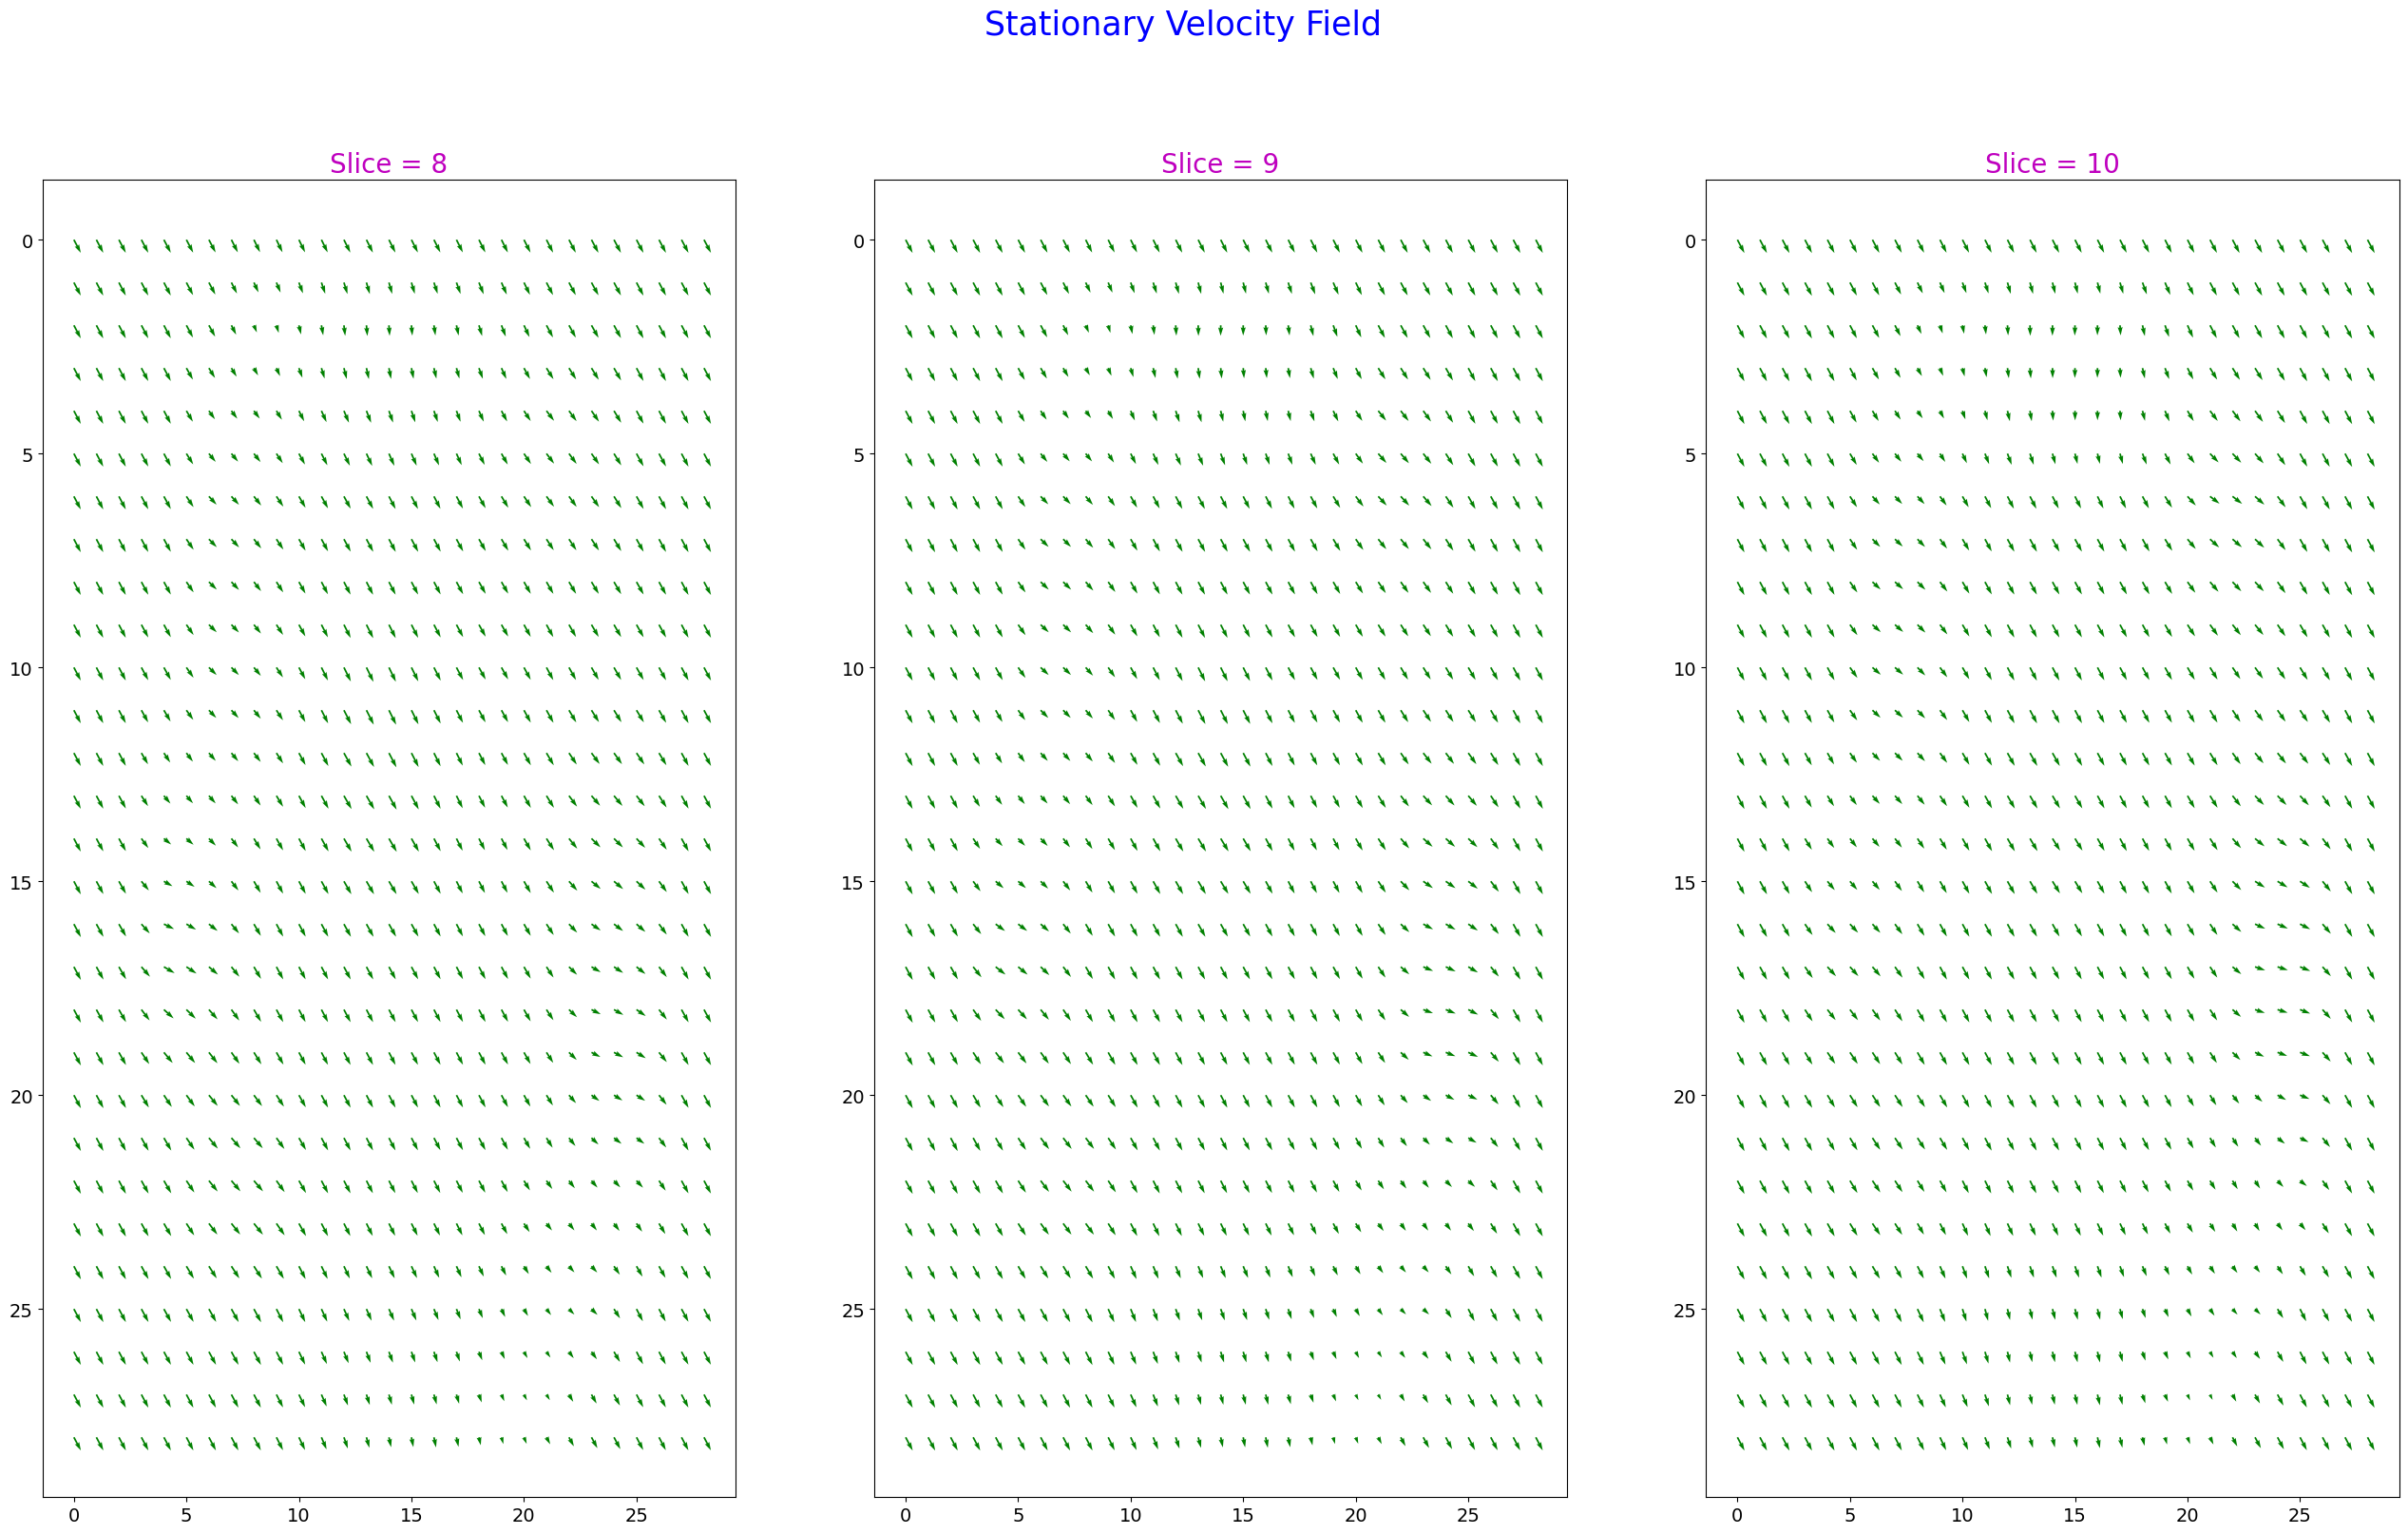

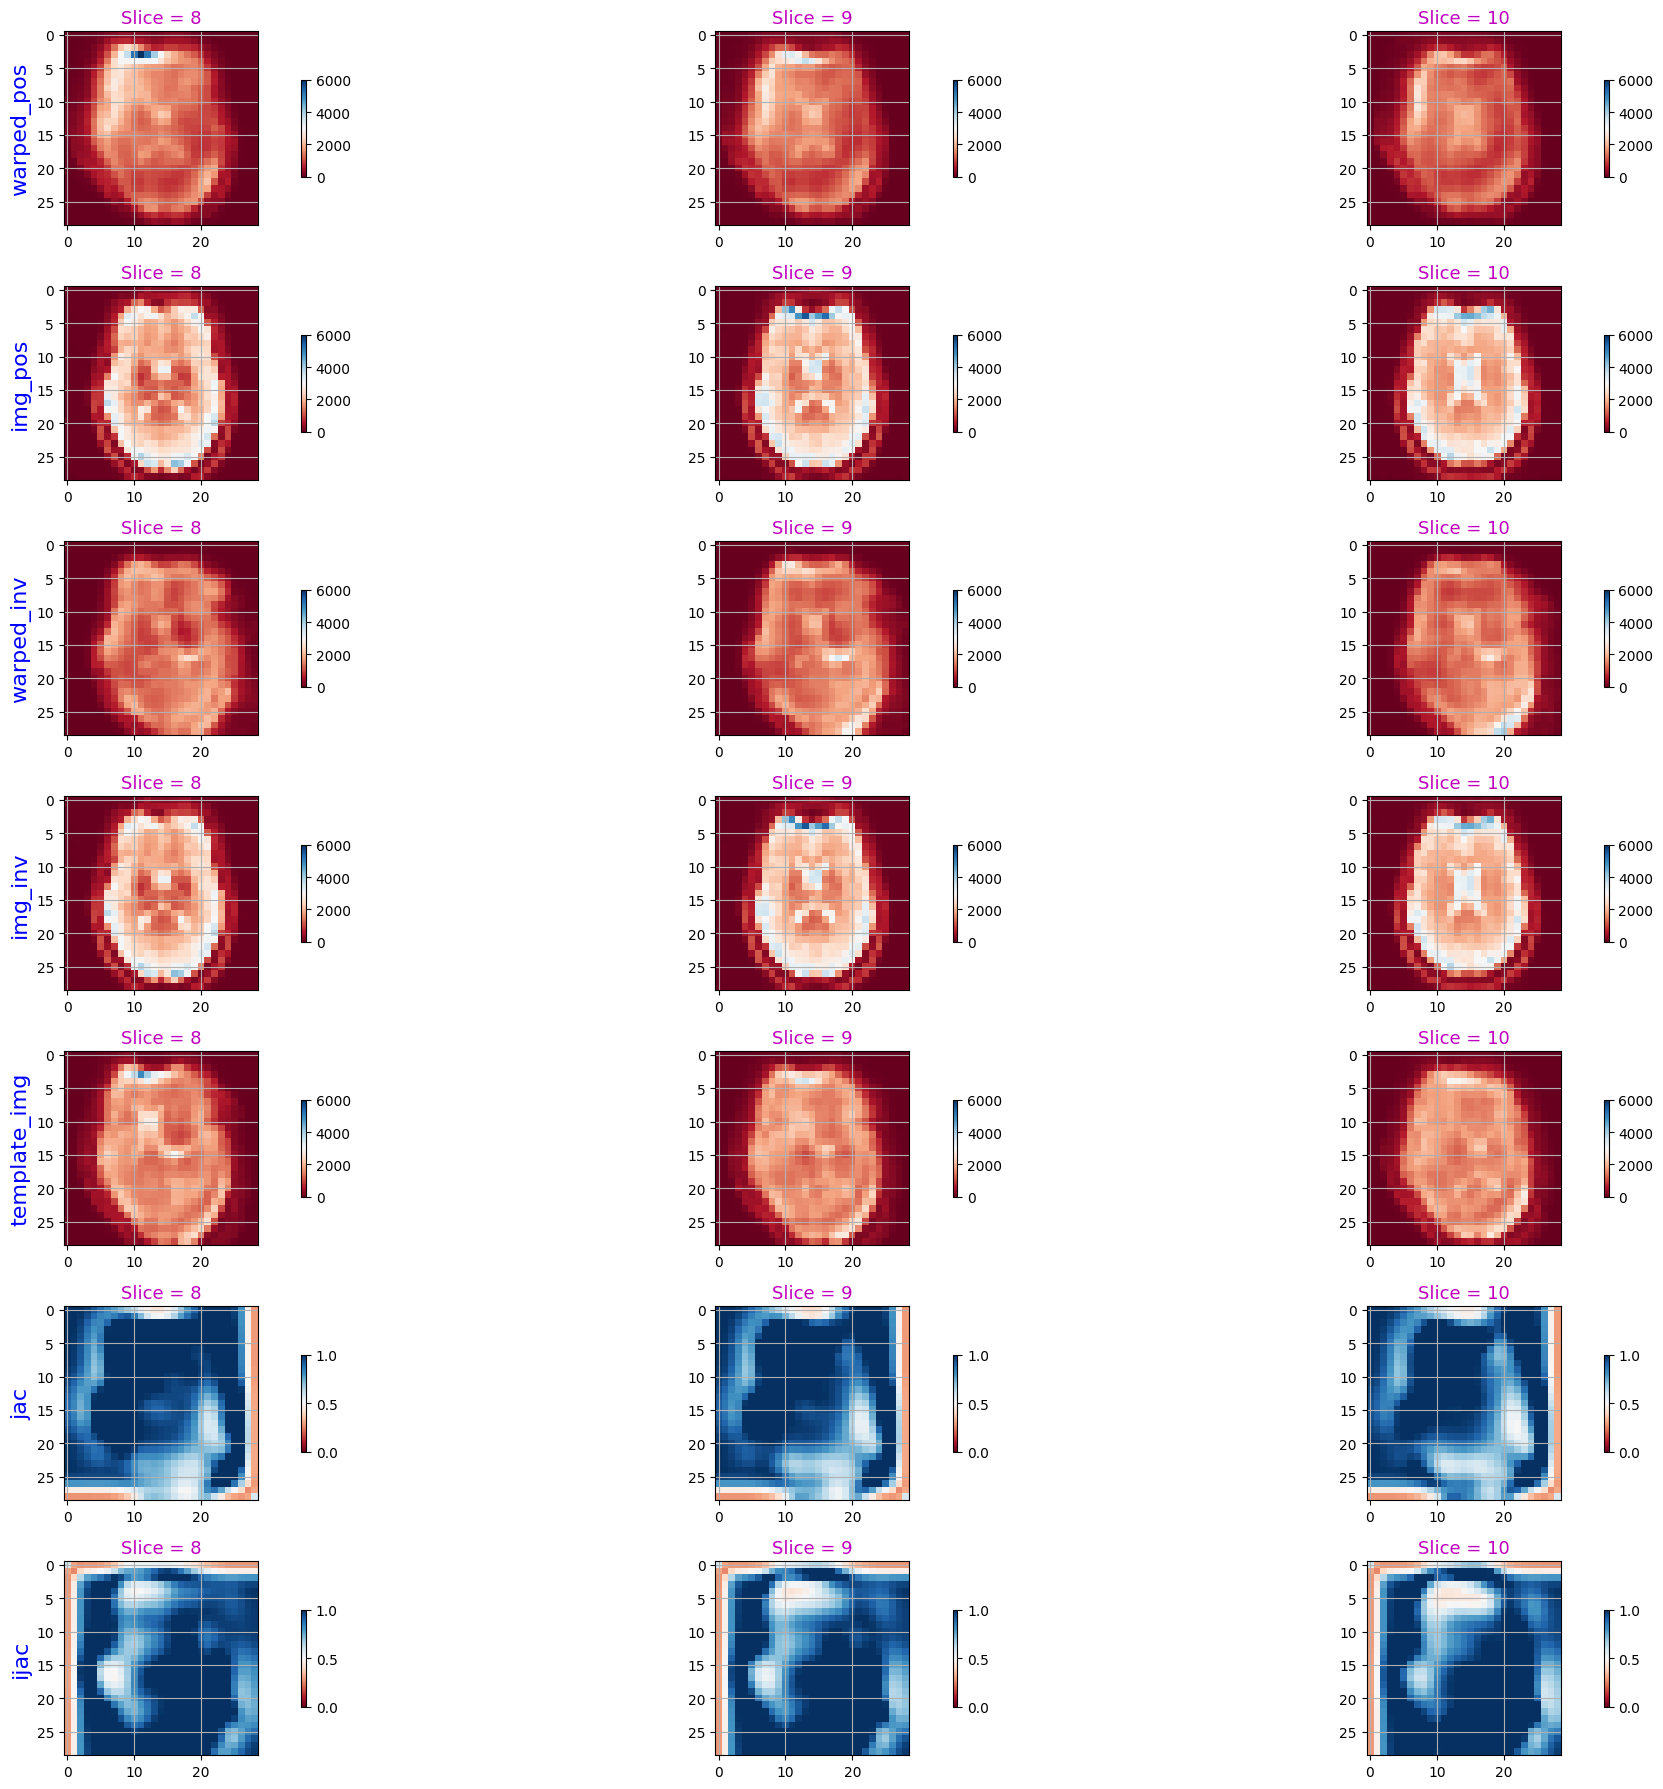

  0%|          | 0/90 [00:00<?, ?it/s]

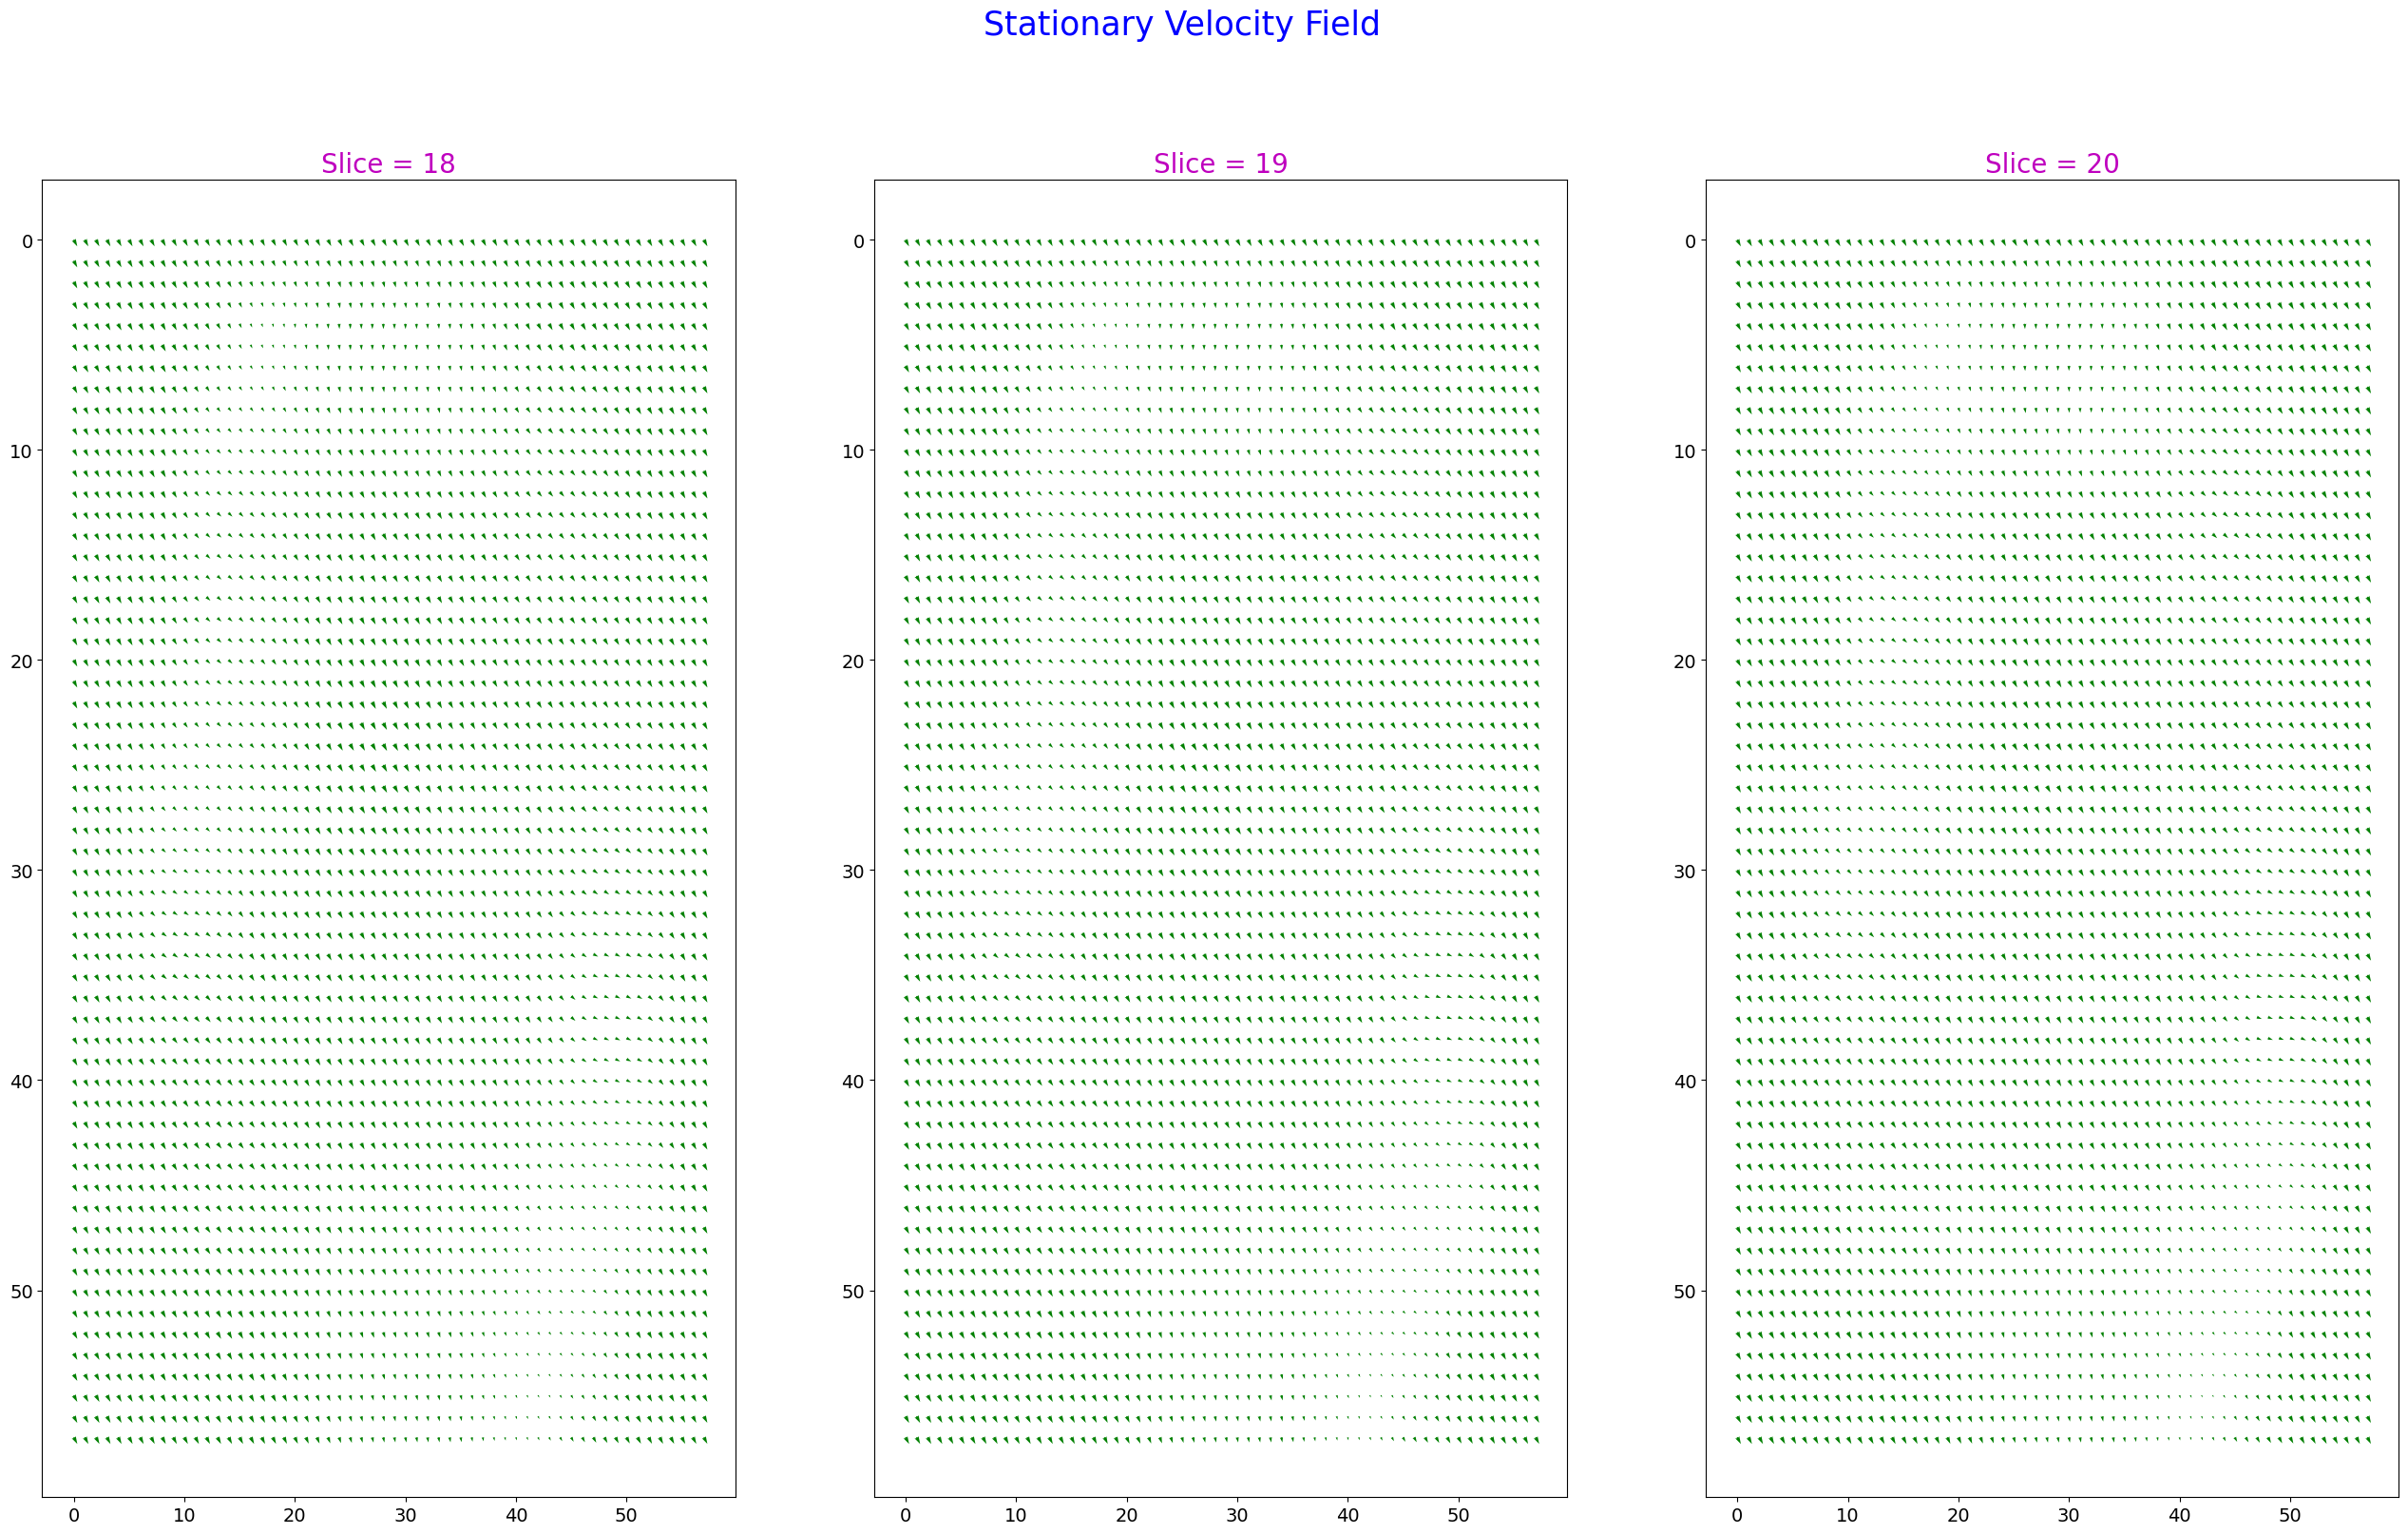

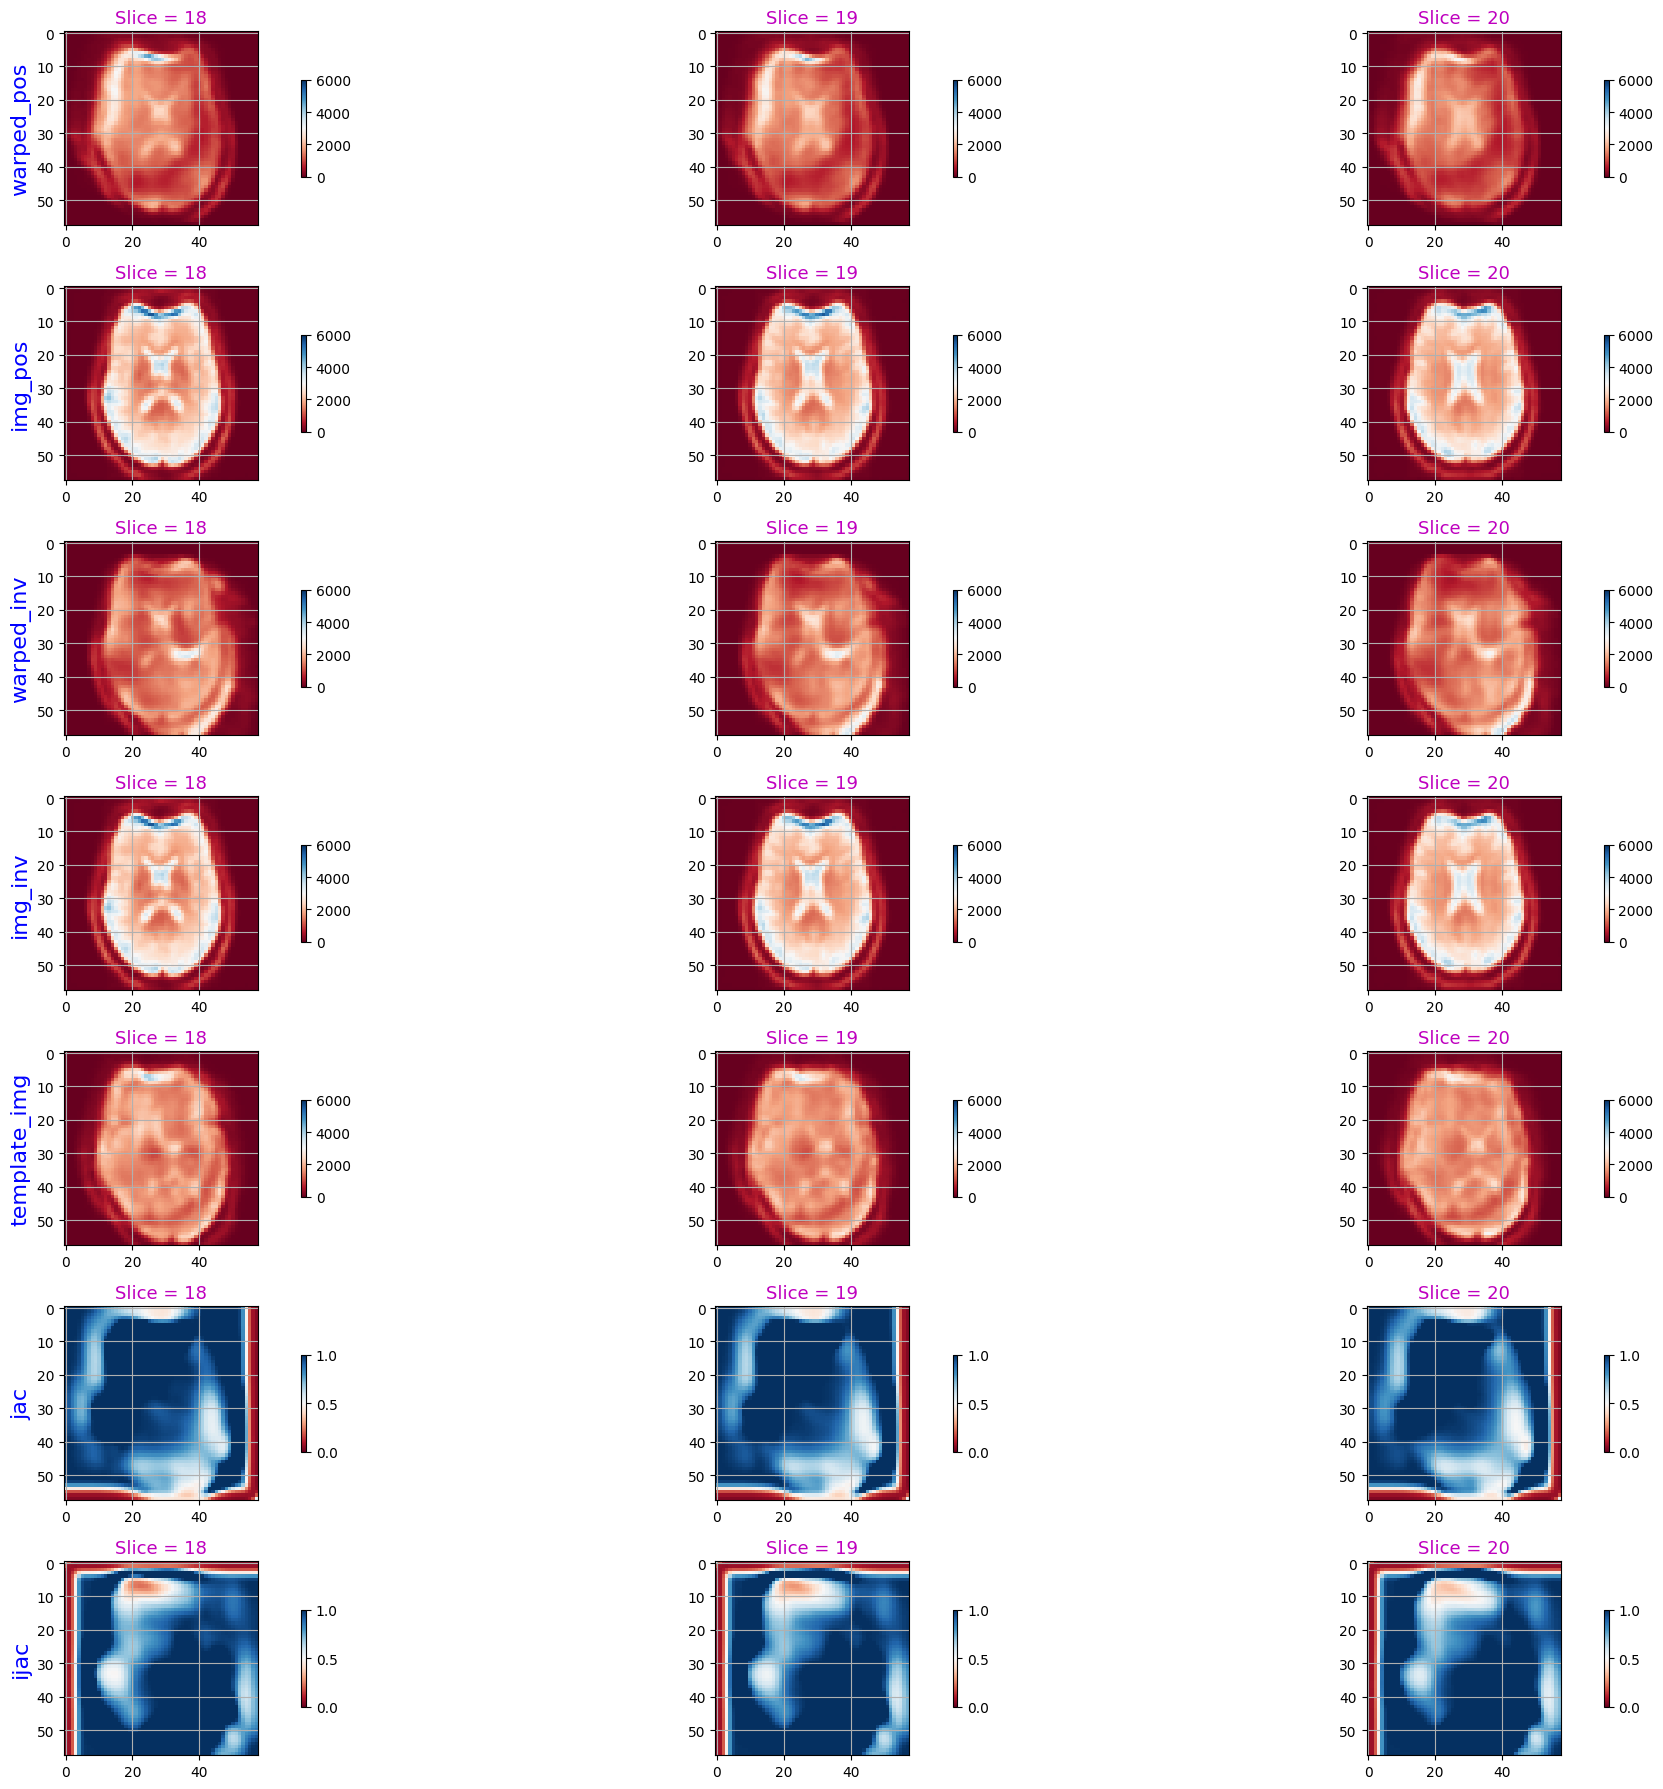

  0%|          | 0/80 [00:00<?, ?it/s]

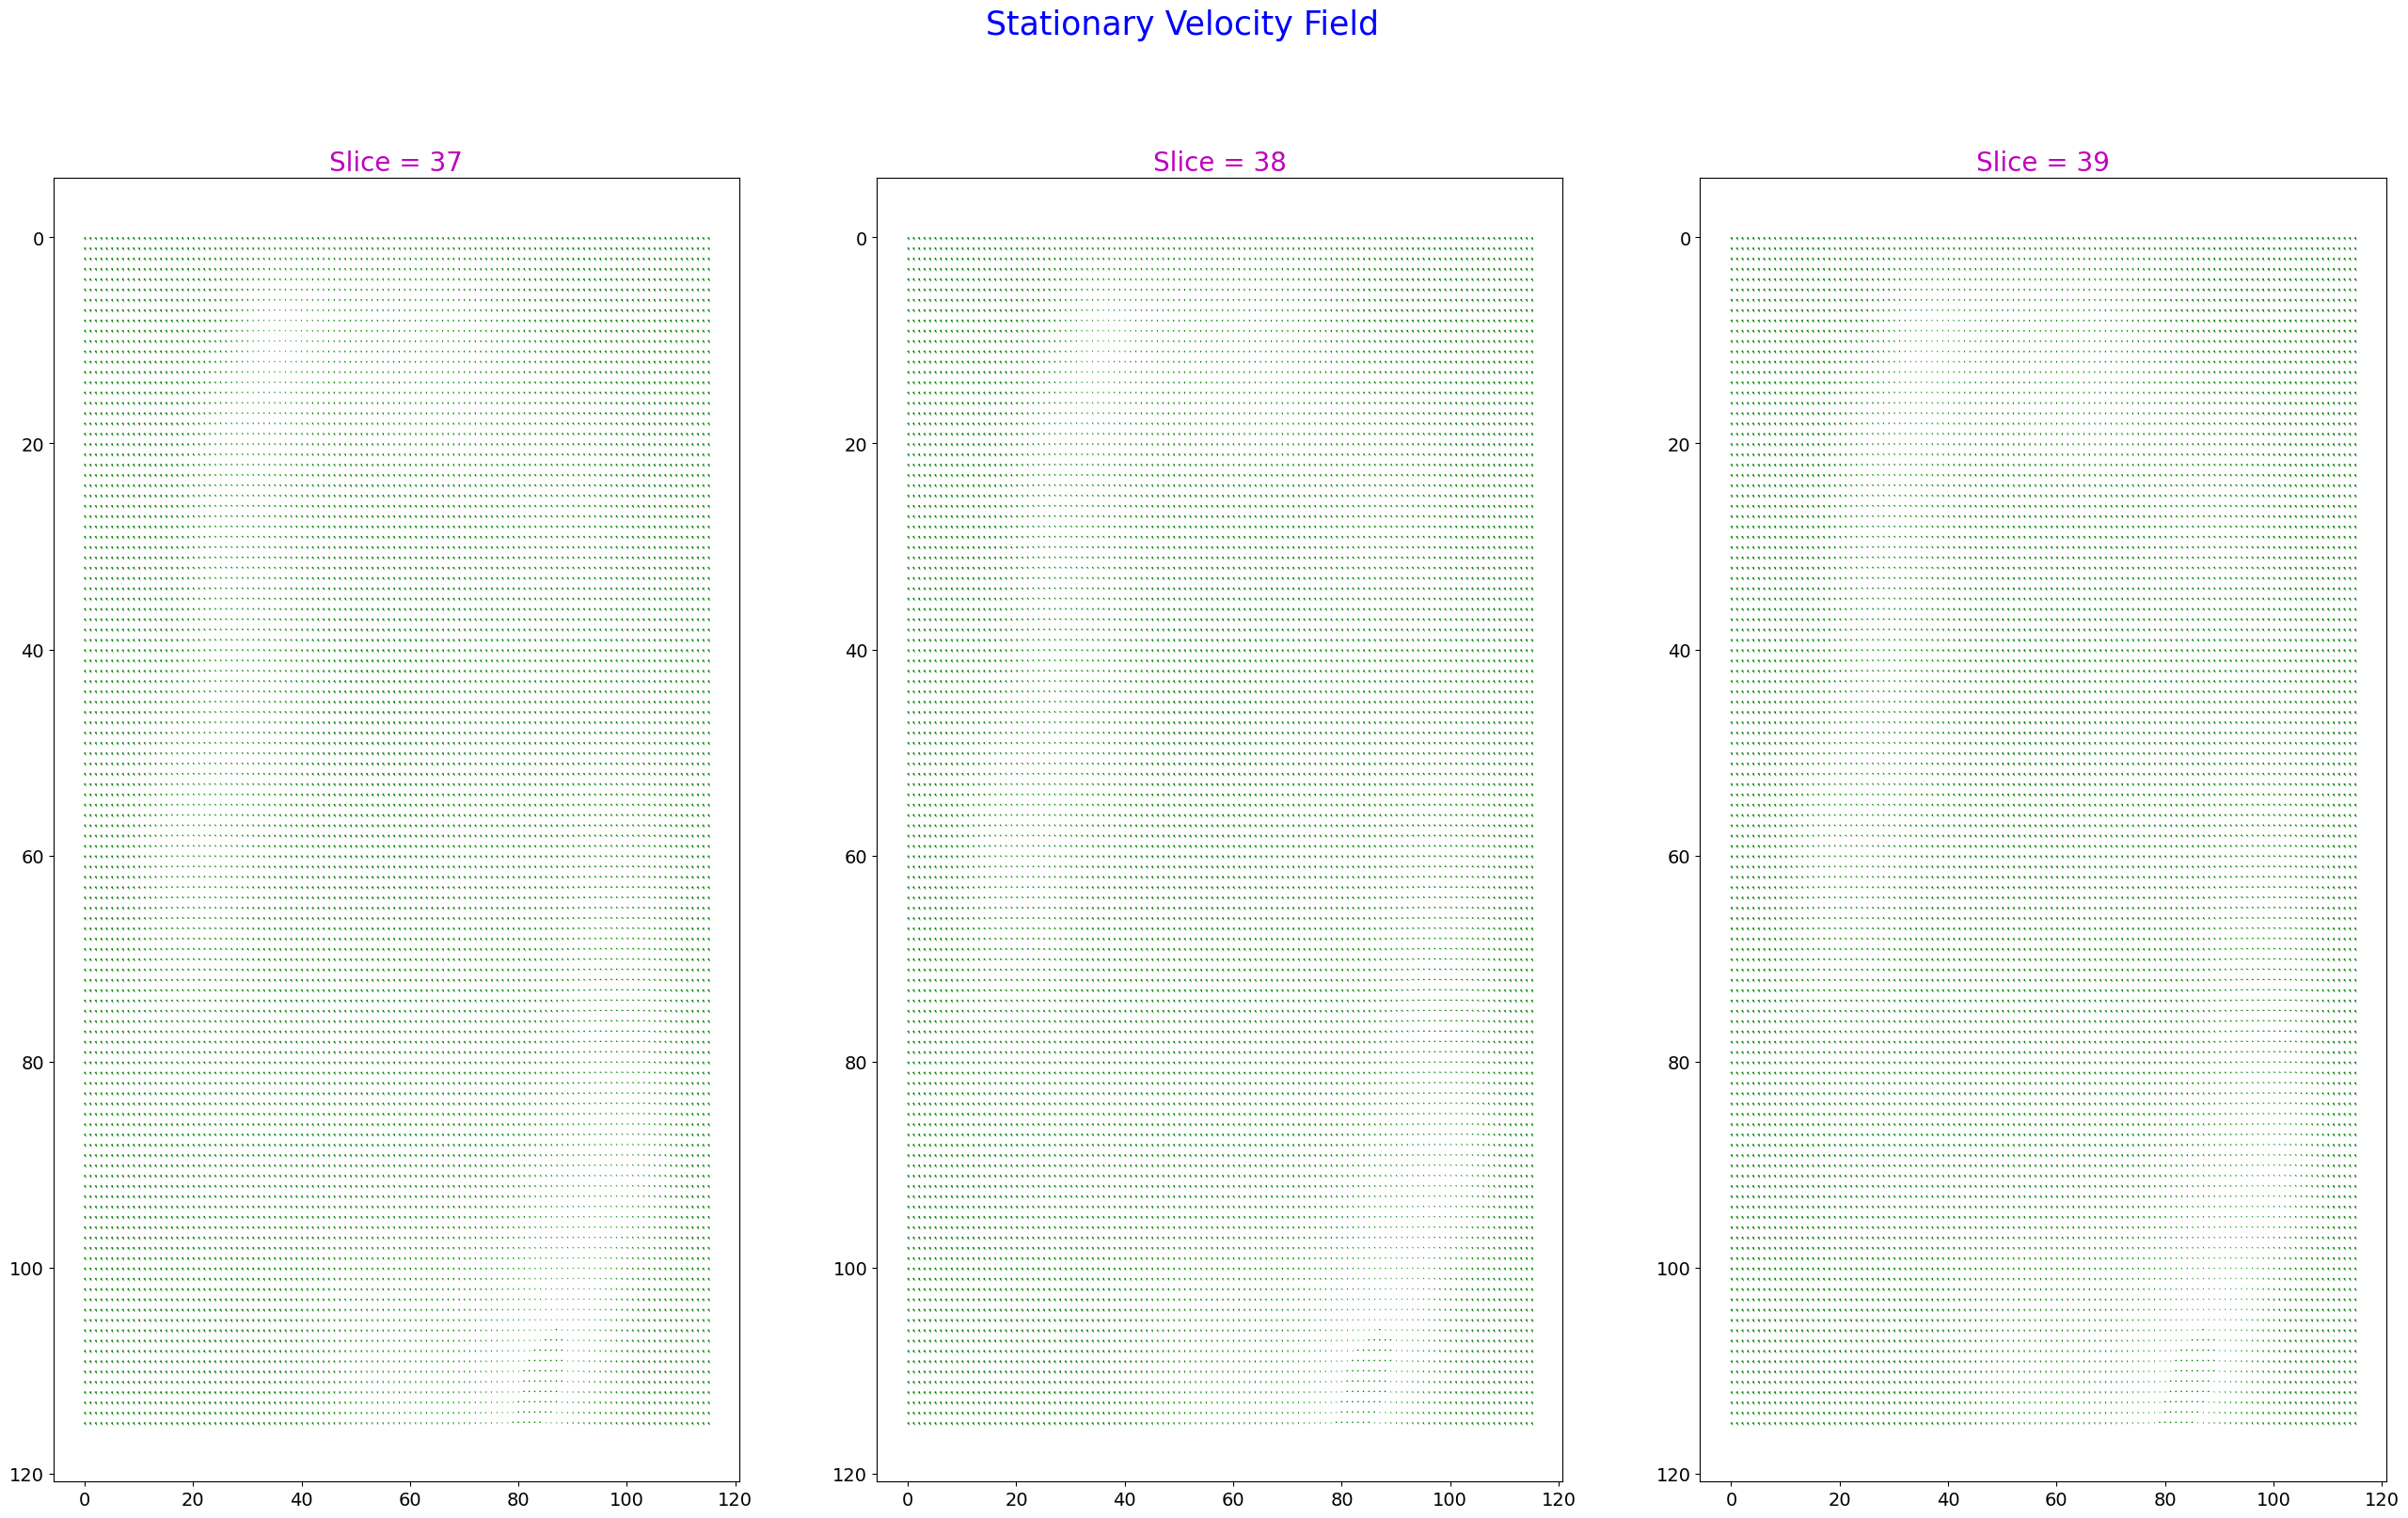

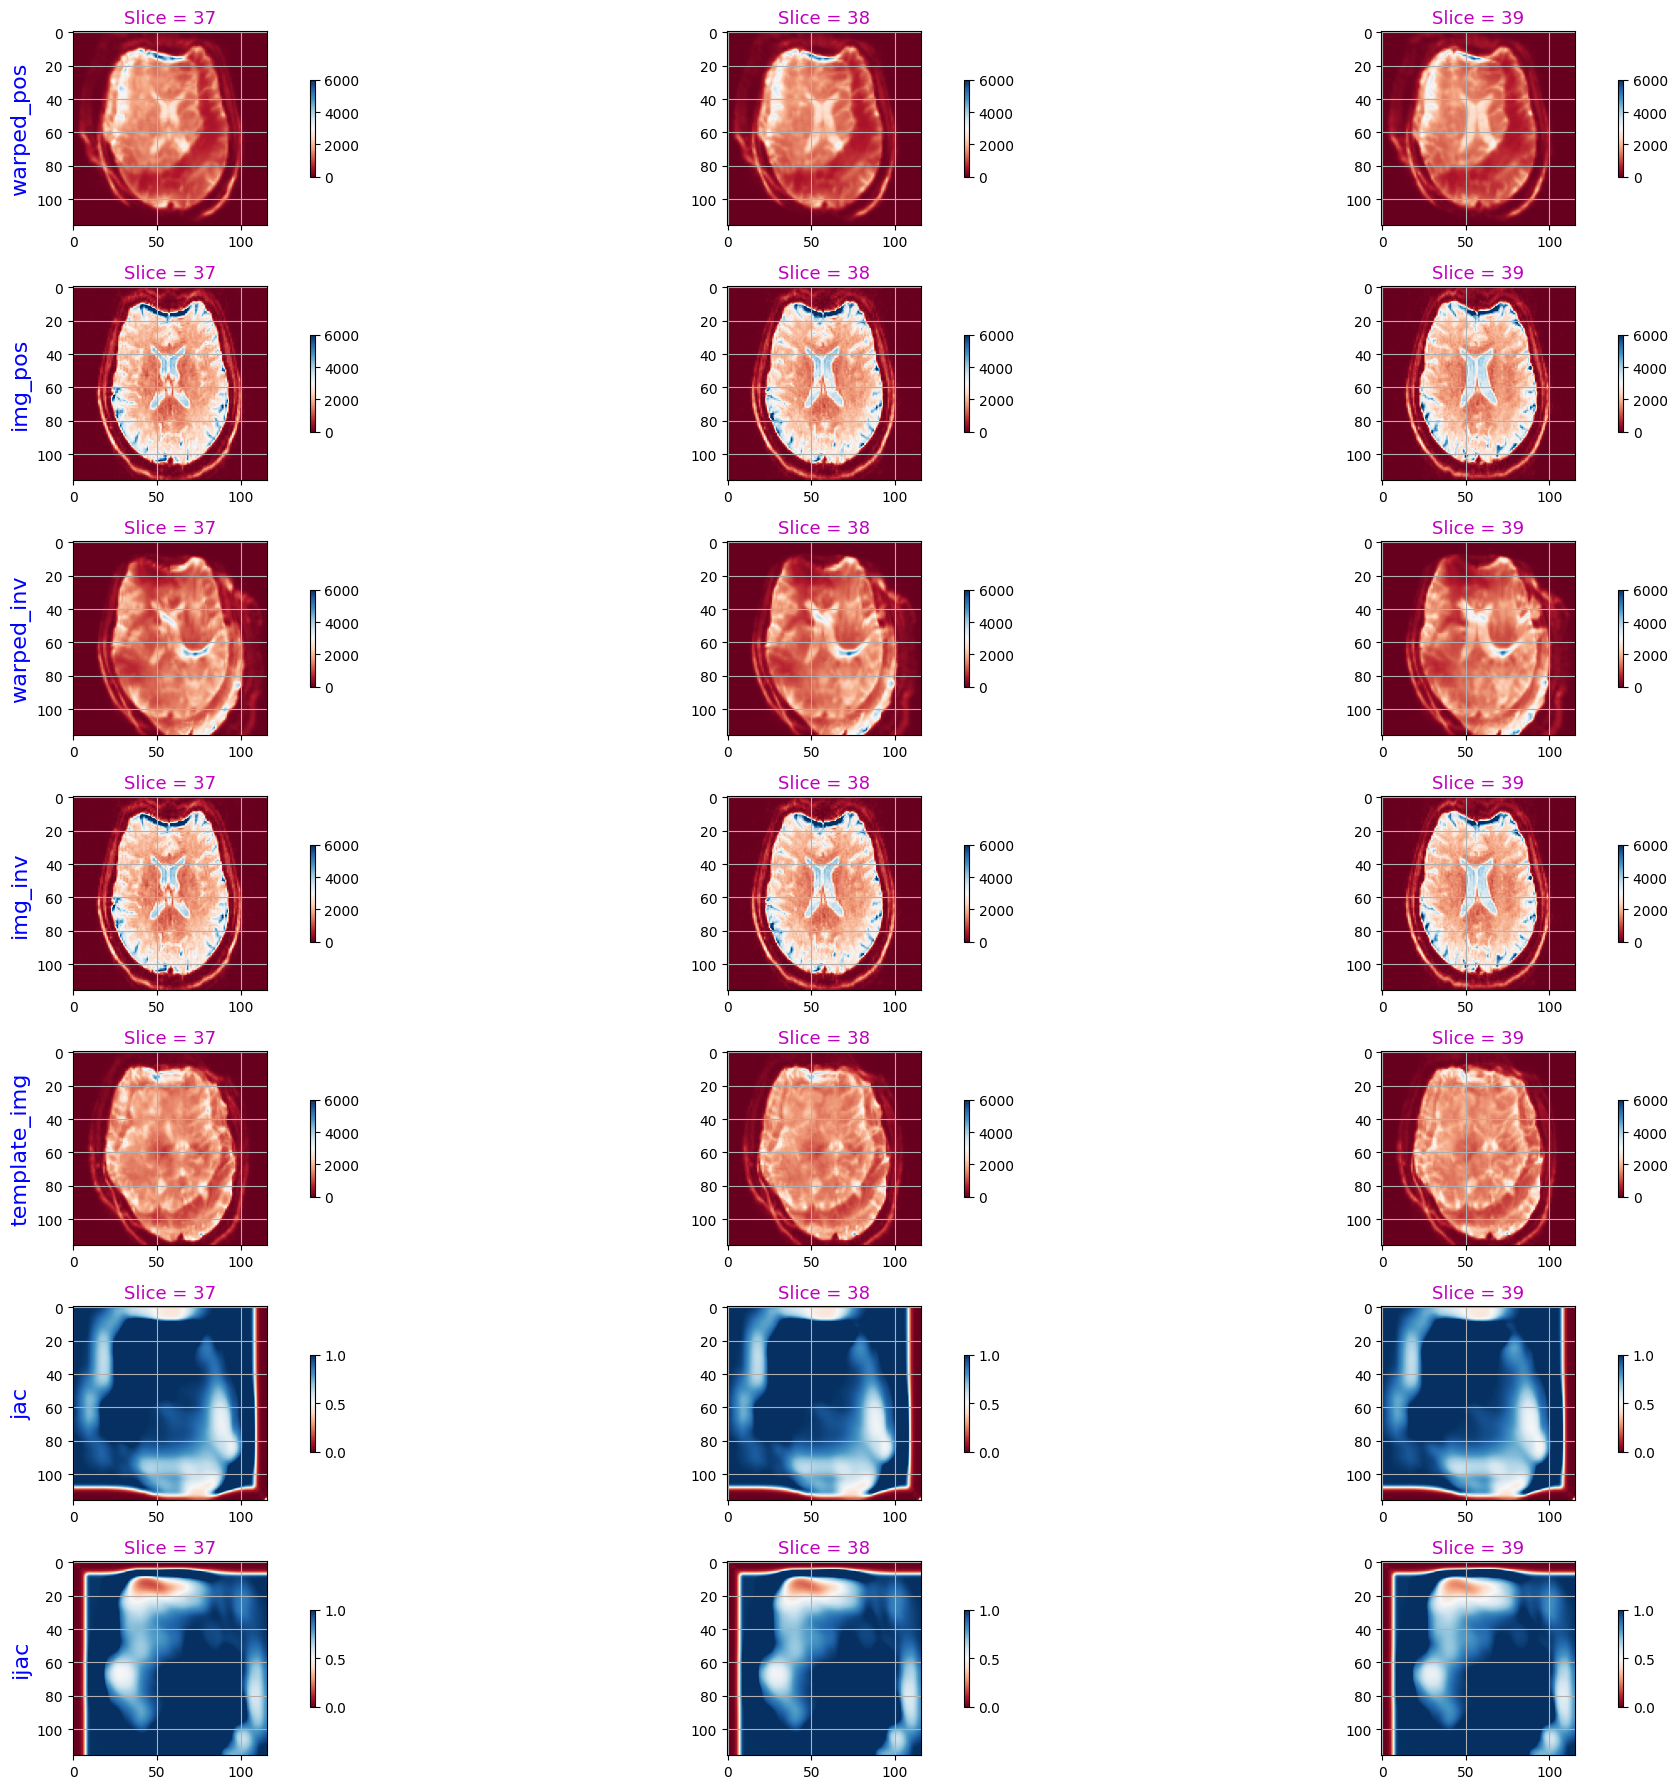

100%|██████████| 80/80 [00:34<00:00,  2.33it/s]


In [245]:
j=0
flag = 0

for i in reversed(range(4)):
    # print(grid.is_leaf,template_img.is_leaf,grid.shape,template_img.shape)
    l3_mux = 1
    if(i==2):
        learning_rate = 0.2
        epochs = 70
        l3_mux = 0.5
    if(i==1):
        learning_rate = 0.5
        epochs = 90
        l3_mux = 0.05
    if(i==0):
        learning_rate = 1.2
        epochs = 80
        l3_mux = 5e-3
    
    optimizer = torch.optim.SGD([template_img, grid], lr=learning_rate)
    flag = 0    
    for t in tqdm(range(epochs)):
        # print(t,grid.is_leaf)
        optimizer.zero_grad()
        # global warped_pos,warped_inv,jac, ijac
        # global flag
        warped_pos,jac = forward_model(template_img, grid, inv = False)
        warped_inv,ijac = forward_model(template_img, grid, inv = True) #(1,1,*spatial)
        
        
        z = [warped_pos.detach().cpu(), img_pos_pyramid[i].detach().cpu(),warped_inv.detach().cpu(),img_inv_pyramid[i].detach().cpu(),template_img.detach().cpu(),jac.detach().cpu(),ijac.detach().cpu()]
        if((t+1)%1==0) and (flag==0):
            slices = [int(warped_pos.shape[-3]/2)-1, int(warped_pos.shape[-3]/2) ,int(warped_pos.shape[-3]/2)+1]
            f = plot_3d_svf(slices, grid.detach().cpu())
            plt_images_2(slices,z,v_list,h_list,vmax_list)
            flag = 1
        
        
        l1 = loss(img_pos_pyramid[i].squeeze(0),warped_pos.squeeze(0),torch.ones_like(img_pos_pyramid[i].squeeze(0)))
        l2 = loss(img_inv_pyramid[i].squeeze(0),warped_inv.squeeze(0),torch.ones_like(img_inv_pyramid[i].squeeze(0)))
        # l3 = reg(grid.squeeze(0).permute(1,2,3,0))
        l3 = reg(grid).mean()
        # l3 = reg(jac).mean() + reg(ijac).mean() #jacobian regularisation
        NLL = 1e-4*(l1) + 1e-4*(l2) + (0.1* l3) #+ torch.from_numpy(jac).abs()
        losses[i].append((l1.item()*1e-4,l2.item()*1e-4,l3.item()*l3_mux)) #To plot l1,l2,l3 seperately
        # print(losses[i])
        NLL.backward(retain_graph=True)
        optimizer.step()
    
    # print("before upsampling", grid.is_leaf,template_img.is_leaf,grid.shape,template_img.shape)

    if(i!=0):
        # upsampler = torch.nn.Upsample(scale_factor=2, mode='bicubic', align_corners=False)
        # print(grid.is_leaf,template_img.is_leaf,grid.shape,template_img.shape)
        # grid = upsampler(grid.squeeze(0))
        # grid = grid.unsqueeze(0) * 2 
        upsampler = layers.ResizeTransform(vel_resize=0.5, ndims=3)
        grid = upsampler(grid)
        # grid = grid.unsqueeze(0)
        '''
        if (i == 3):
            pad1 = (0,1,0,1) #To pad the template image
            grid = F.pad(grid, pad1, "constant", 0)
        '''
        if(i==3):
            grid = grid[:,:,:-1,:-1,:-1] #reshaping from (1,3,20,30,30) to (1,3,19,29,29)
        

        warped_pos,jac = forward_model(img_pos_pyramid[i-1][None].float(), grid, inv = False)
        warped_inv,ijav = forward_model(img_inv_pyramid[i-1][None].float(), grid, inv = True)
        template_img = ((warped_pos+warped_inv)/2).float()
        # print("after upsampling", grid.is_leaf,template_img.is_leaf,grid.shape,template_img.shape)
        # print("ddsfdsf",grid.shape,img_pos_pyramid[i-1][None].float().shape,template_img.dtype,grid.dtype)
    
    template_img.retain_grad()
    grid.retain_grad()

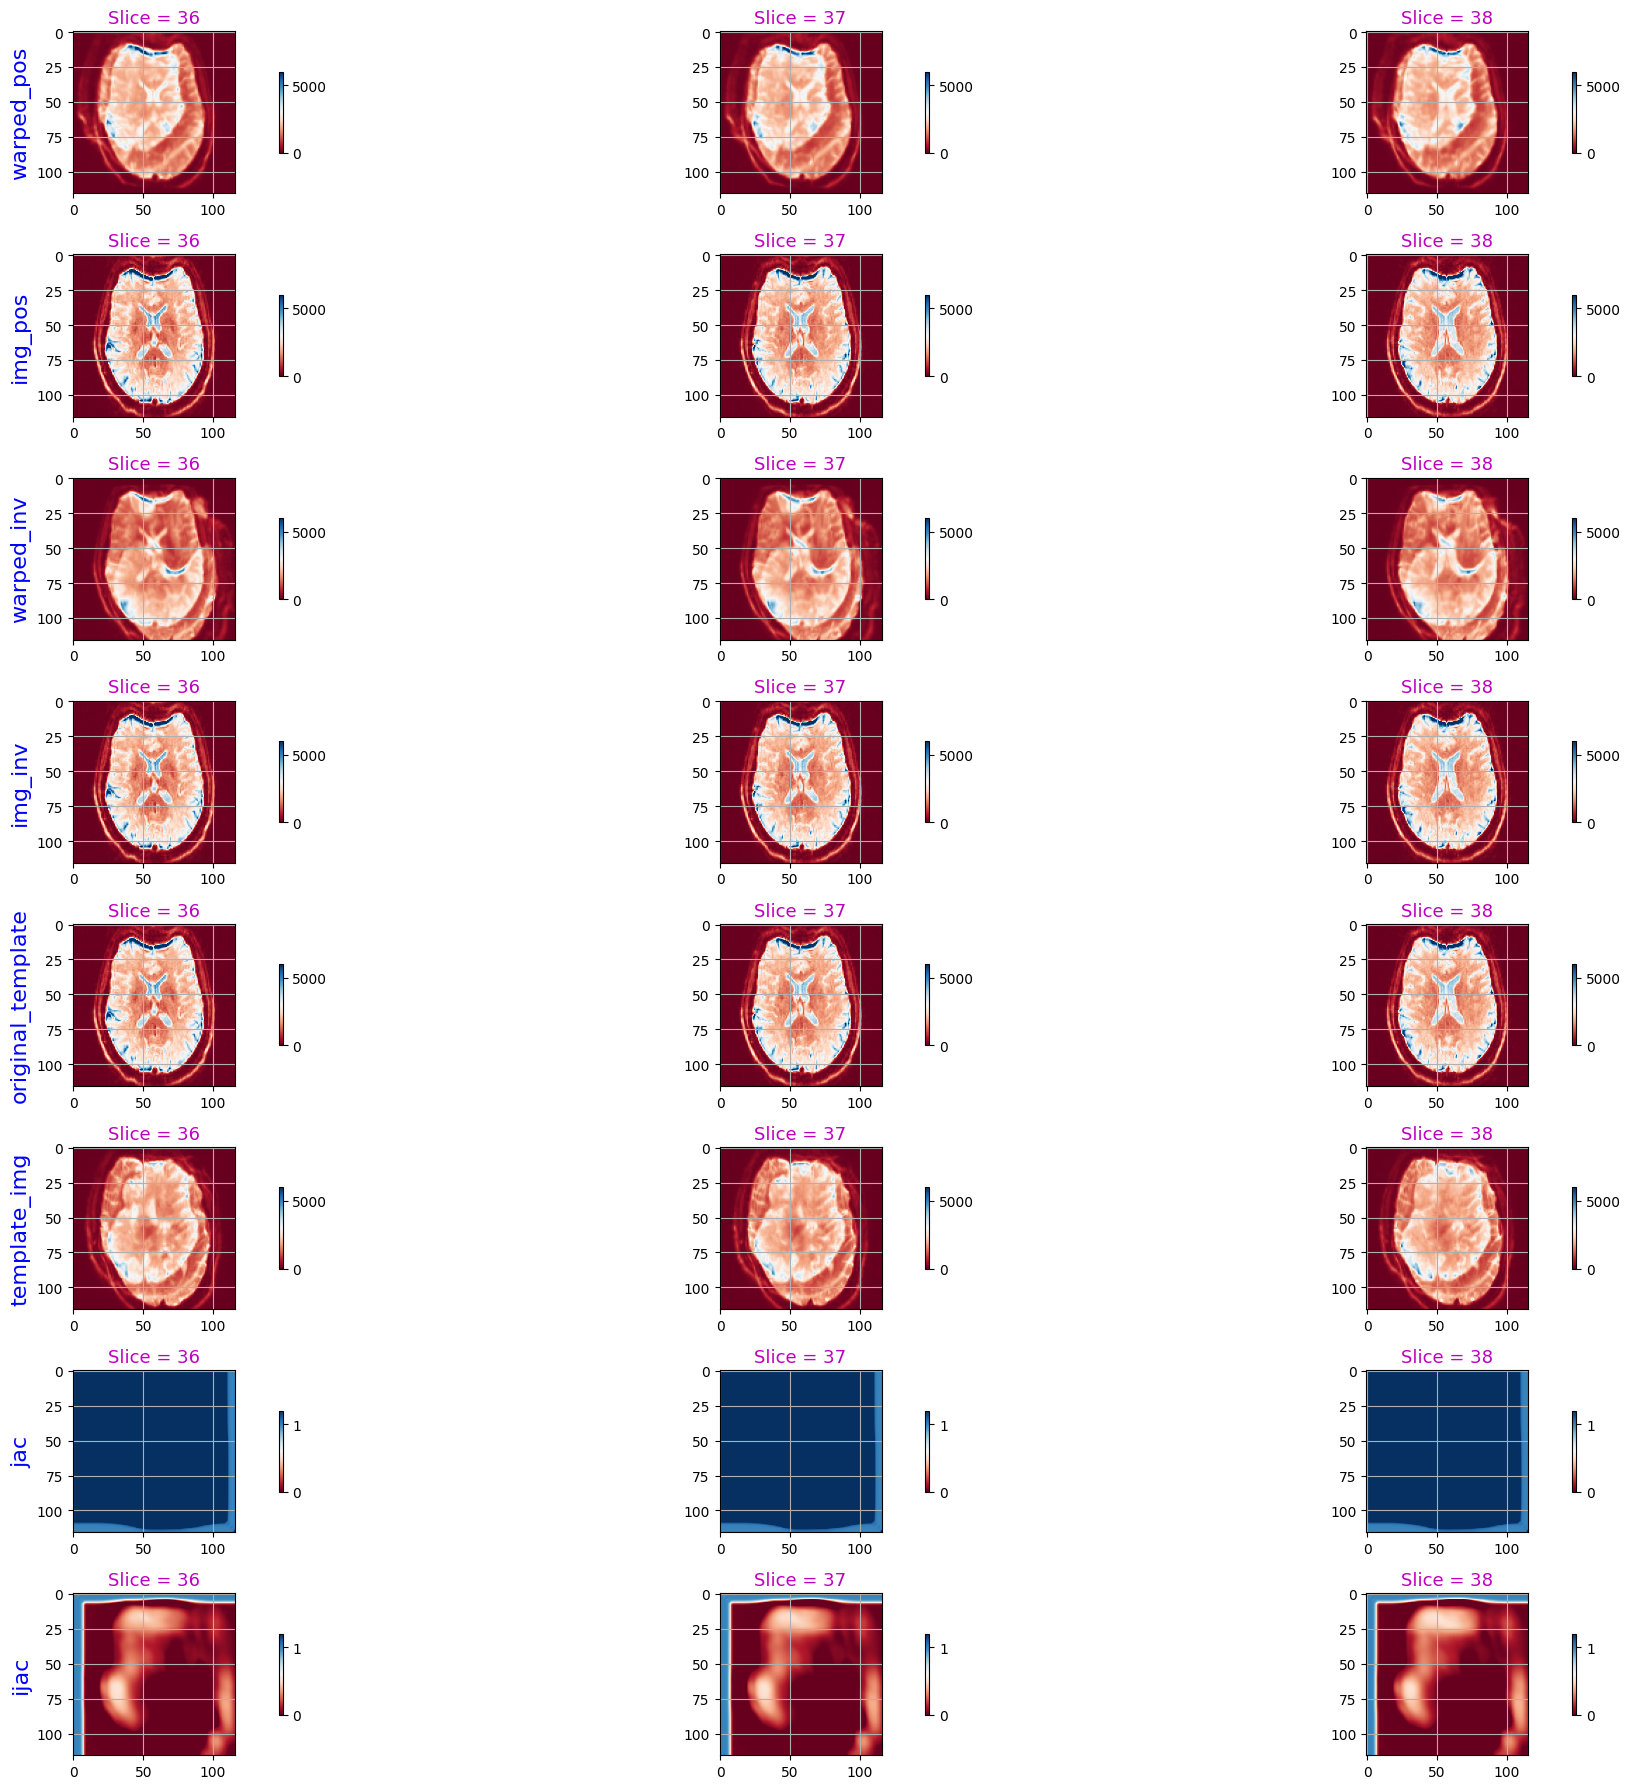

In [230]:
#Plotting 
vmax_list = [6000,6000,6000,6000,6000,6000,1.2,1.2]
v_list = ["warped_pos","img_pos","warped_inv","img_inv","original_template","template_img","jac","ijac"]
h_list = ["magnitude","magnitude","magnitude","magnitude","magnitude", "magnitude", "log", "log"]
slices = [36,37,38]
original_template = (img_pos_pyramid[0] + img_inv_pyramid[0])/2
z = [warped_pos.detach().cpu(), img_pos_pyramid[i].detach().cpu(), warped_inv.detach().cpu(), img_inv_pyramid[i].detach().cpu(), original_template.detach().cpu() ,template_img.detach().cpu(), jac.detach().cpu(), ijac.detach().cpu()]
# f = plot_3d_svf(slices, grid.detach().cpu())
plt_images_2(slices,z,v_list,h_list,vmax_list)

In [ ]:
#Plotting Final Template Image

optimized_grid = grid 
new_template = (img_pos_pyramid[0] + img_inv_pyramid[0])/2

warped_pos,jac = forward_model(img_pos_pyramid[0][None].float(), optimized_grid)
warped_inv,ijav = forward_model(img_inv_pyramid[0][None].float(), -optimized_grid)
warped = (warped_pos+warped_inv)/2

warped2, jac = forward_model(new_template[None].float(), optimized_grid)
# warped = spatial.grid_pull(new_template, optimized_grid, bound=bound1, extrapolate=extrapolate) *(jac_det+1)
# warped,_ = forward(new_template,optimized_grid,False)
# optimized_grid = spatial.add_identity_grid(optimized_grid)
vmax_list = [6000,6000,6000,6000,6000,6000,6000]
v_list = ["warped_pos","img_pos","warped_inv","img_inv","template_img","final_img","final_img_2"]
h_list = ["magnitude","magnitude","magnitude","magnitude","magnitude","magnitude","magnitue"]
slices = [36,37,38]
print(grid.shape,template_img.shape)
z = [warped_pos.detach().cpu(), img_pos_pyramid[0].detach().cpu(), warped_inv.detach().cpu(), img_inv_pyramid[0].detach().cpu(), new_template.detach().cpu(), warped.detach().cpu(), warped2.detach().cpu()]
# f = plot_3d_svf(slices, grid.detach().cpu())
plt_images_2(slices,z,v_list,h_list,vmax_list)

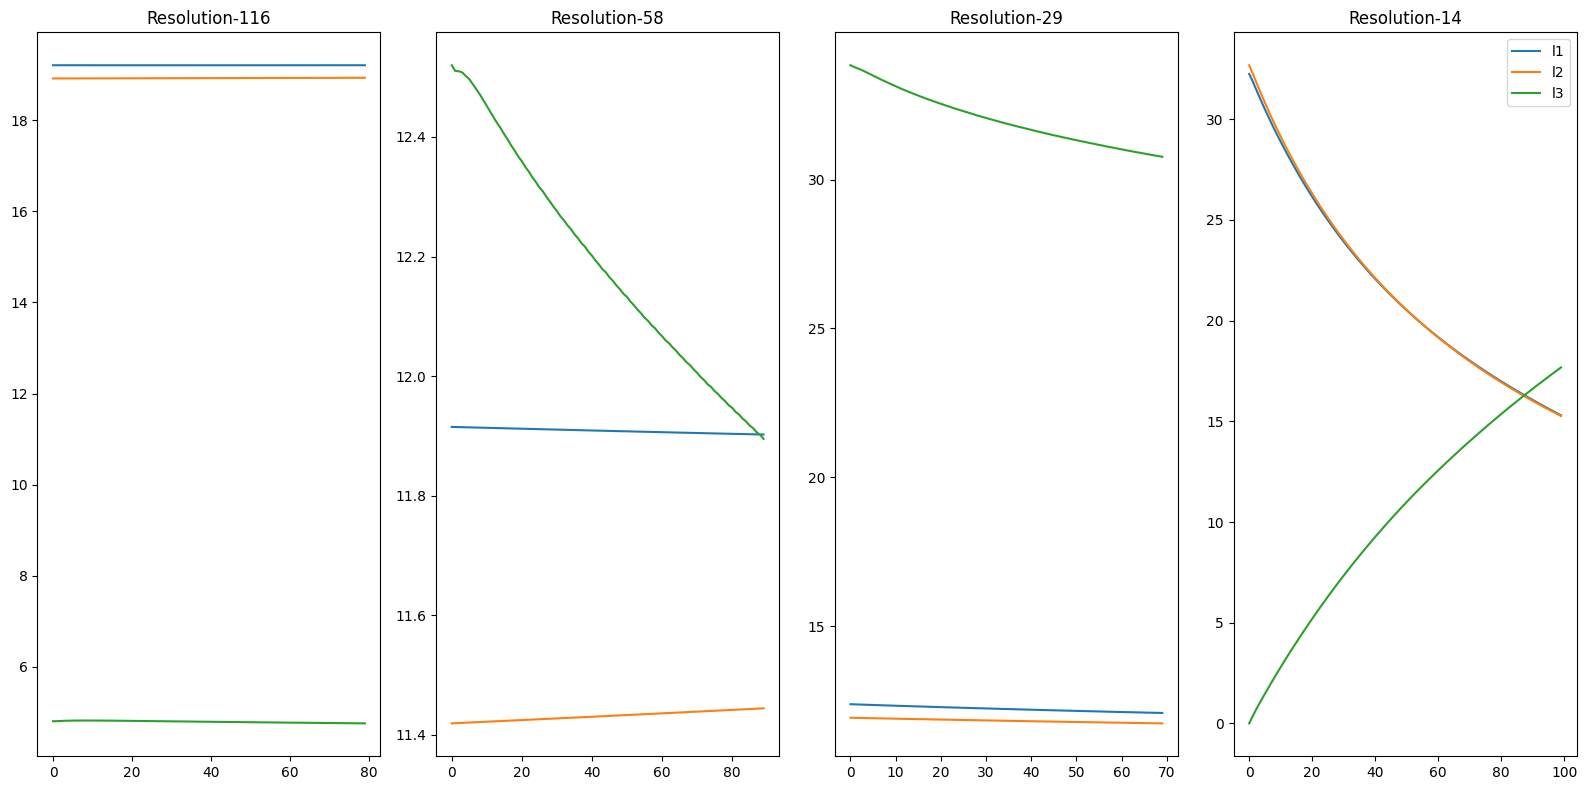

In [241]:
#0 will be highest resolution
f, ax = plt.subplots(1,4)
f.set_figheight(8)
f.set_figwidth(16)


ax[0].plot(range(len(losses[0])),losses[0])
ax[0].title.set_text('Resolution-116')
ax[1].plot(range(len(losses[1])),losses[1])
ax[1].title.set_text('Resolution-58')
ax[2].plot(range(len(losses[2])),losses[2])
ax[2].title.set_text('Resolution-29')
ax[3].plot(range(len(losses[3])),losses[3])
ax[3].title.set_text('Resolution-14')


f.tight_layout()

plt.legend(['l1','l2','l3'])
plt.show()

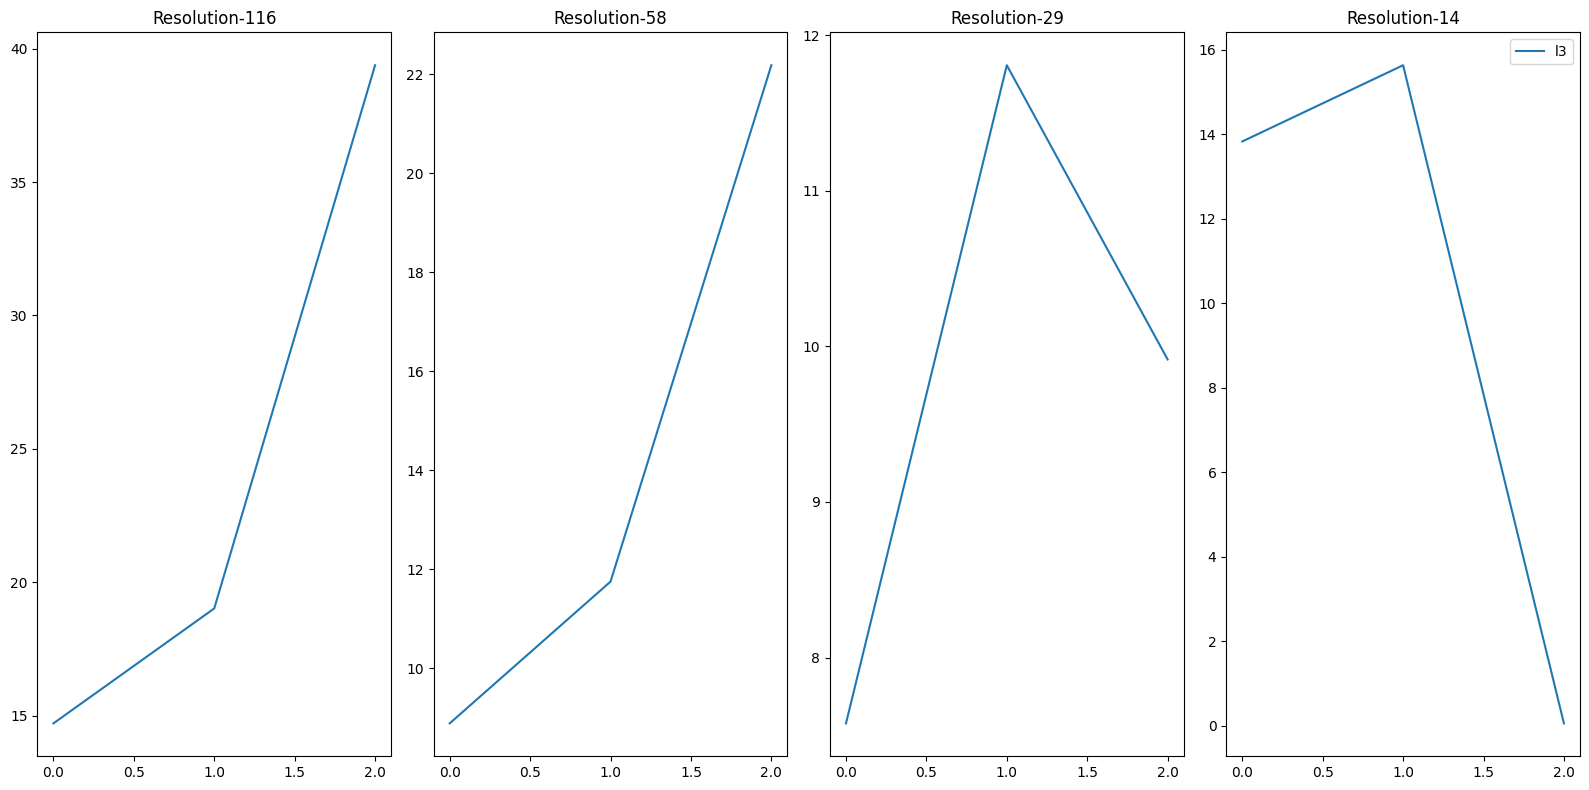

In [29]:
#0 will be highest resolution
f, ax = plt.subplots(1,4)
f.set_figheight(8)
f.set_figwidth(16)


ax[0].plot(losses[0][2])
ax[0].title.set_text('Resolution-116')

ax[1].plot(losses[1][2])
ax[1].title.set_text('Resolution-58')
ax[2].plot(losses[2][2])
ax[2].title.set_text('Resolution-29')
ax[3].plot(losses[3][2])
ax[3].title.set_text('Resolution-14')


f.tight_layout()

plt.legend(['l3'])
plt.show()

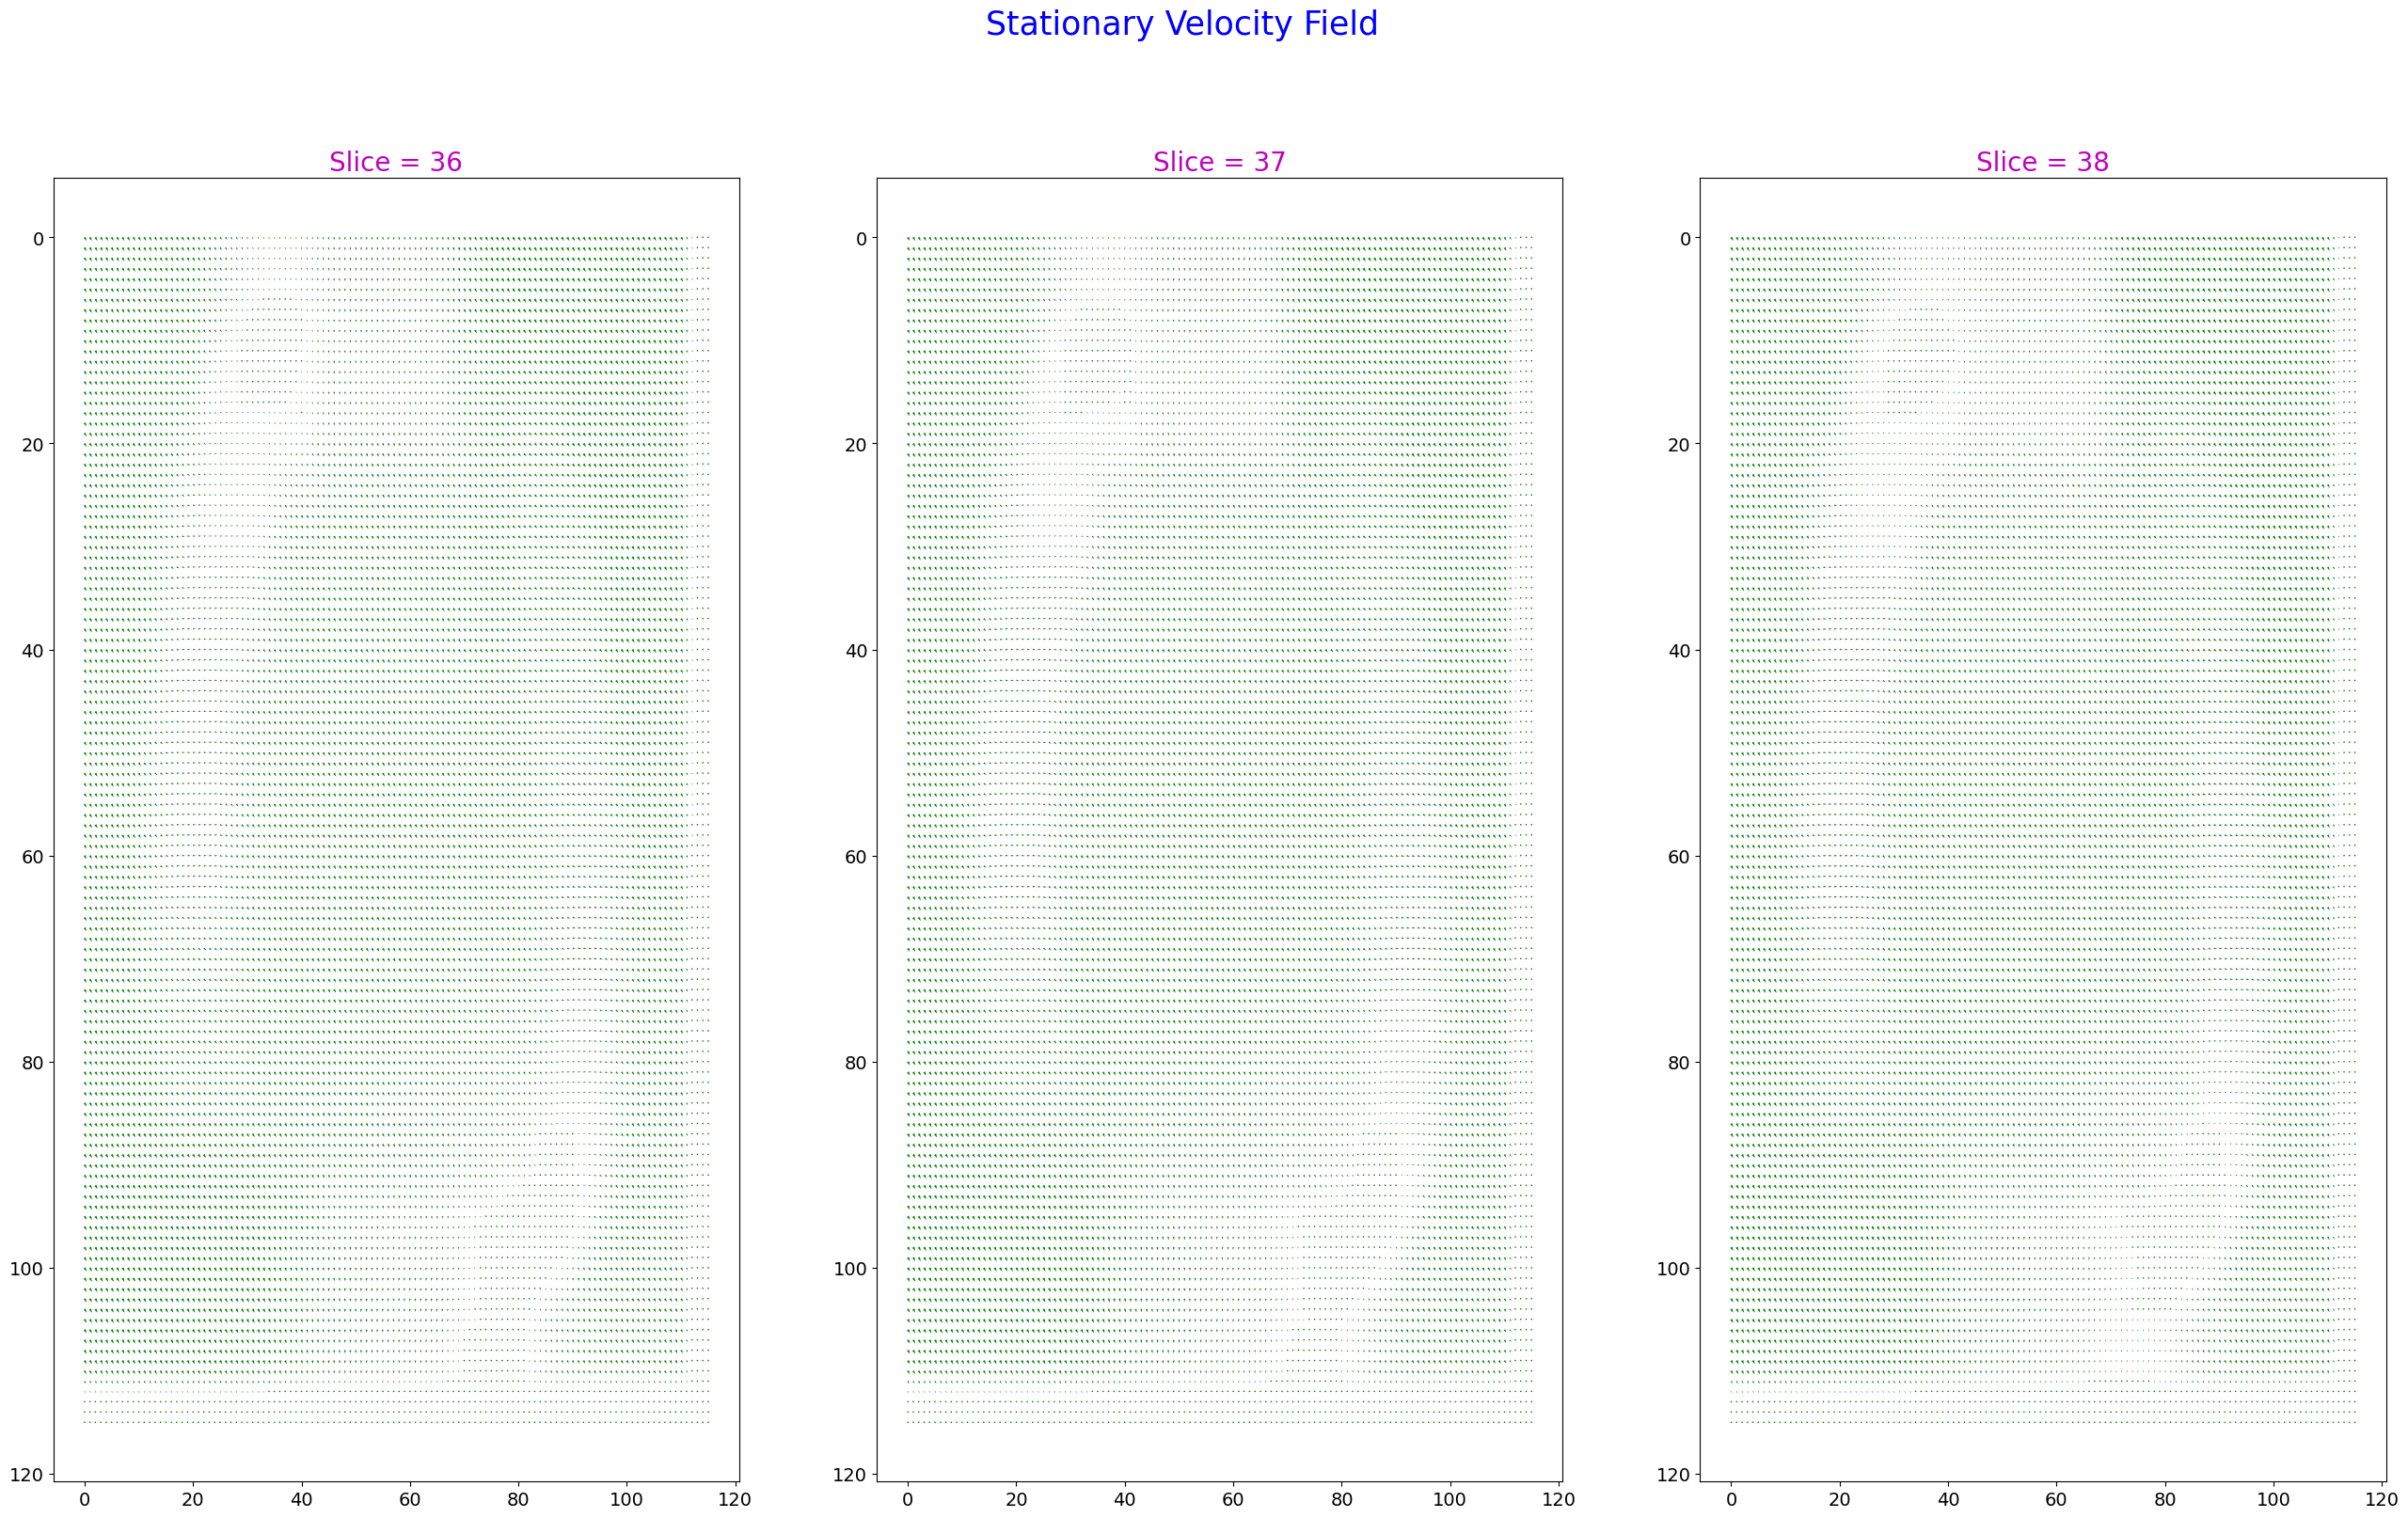

In [31]:
f = plot_3d_svf(slices, grid.detach().cpu()[:,:,:,:,:])

In [30]:
losses[0]

[(148.10233492059143, 776.9701439597925, 35.523825073242186),
 (163.44731488775395, 839.5841890901721, 37.564944458007815),
 (148.1167674003543, 772.9941133094106, 37.4451904296875),
 (163.46734995964601, 836.8517830330035, 38.48079528808594),
 (148.0002833514866, 770.0381813866649, 38.340911865234375),
 (163.45876461868943, 834.5808486098307, 38.693414306640626),
 (147.89612896403287, 767.6687892099517, 38.46642150878907),
 (163.44914323091885, 832.6833368082299, 38.62634887695313),
 (147.7928399288928, 765.2540695415366, 38.42914733886719),
 (163.4393642517894, 830.922186363113, 38.49389343261719),
 (147.72500709895587, 763.0792207833728, 38.295416259765624),
 (163.4203064664129, 829.2476849986181, 38.37631530761719),
 (147.65403962938828, 761.1549563900666, 38.217306518554686),
 (163.40441807527012, 827.599652779987, 38.27033996582031),
 (147.57678300934984, 759.4553519236968, 38.12432861328125),
 (163.40124681415006, 826.0130642647059, 38.16494445800782),
 (147.5137427812682, 757.6